# IEOR4725 Group Project

* Akiva Bachrach
* Chun Yat (Frankie) Yeung
* Jingyi (Bianca) Bai
* Kirill Krupenin
* Neeraj Sudhakar

# Dataset

Good Judgement Project (GJP)

* `ifps.csv`: market meta-data e.g. ids, questions
* `pm_transactions.lum1.yr2.csv`: order flow e.g. timestamps, trade prices
* `survey_fcasts.yr1.csv`: forecasts (unused)

# Goal

Develop profitable trading strategies on liquid binary prediction markets using order-flow datasets from GJP

# References

* All GJP datasets, https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/BPCDH5

# Import Packages and Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def init():
    # import data and filter for liquid binary markets
    df_ifp = pd.read_csv('/content/drive/MyDrive/IEOR4725 Prediction Market/data/ifps.csv', encoding='unicode_escape')
    df_ord = pd.read_csv('/content/drive/MyDrive/IEOR4725 Prediction Market/data/pm_transactions.lum1.yr2.csv')

    df_ifp['ifp_id'] = df_ifp['ifp_id'].apply(lambda x: x.split('-')[0])
    df_ord['IFPID'] = df_ord['IFPID'].astype('str').apply(lambda x: x.split('.')[0])
    df_ord['matching.order.ID'] = df_ord['matching.order.ID'].astype('str').apply(lambda x: x.split('.')[0])
    df_ord['timestamp'] = pd.to_datetime(df_ord['timestamp'])

    print('columns:')
    print(df_ifp.columns)
    print(df_ord.columns)
    print('-'*50)

    print('preview:')
    print(df_ifp.head())
    print(df_ord.head())
    print('-'*50)

    ifp = dict()
    ord_id = df_ord['IFPID'].to_list()
    for i, row in df_ifp.iterrows():
        id = row['ifp_id']
        if id in ord_id:
            log = df_ord[df_ord['IFPID']==id]

            order_log = log[log['Op.Type']=='SubmitOrder'].copy()
            idx_buy = ~(order_log['buy']^order_log['long'])
            order_log['buy_sell'] = idx_buy
            order_log['signed_qty'] = order_log['qty']*(2*idx_buy-1)
            
            trade_log = log[log['Op.Type']=='Trade'].copy()
            idx_buy = ~(trade_log['buy']^trade_log['long'])
            trade_log['buy_sell'] = idx_buy
            trade_log['signed_qty'] = trade_log['qty']*(2*idx_buy-1)
            
            wm = lambda x: np.average(x, weights=trade_log.loc[x.index,'qty'])
            trade_agg = trade_log.groupby('timestamp').agg(price=('price',wm), qty=('qty','sum'))
            
            trade_cnt = trade_log.groupby('user.ID').size()
            
            n_trades = len(trade_log)
            n_orders = len(order_log)
            
            usr_ids = log['user.ID'].unique()
            usr_log = dict()
            for usr in usr_ids:
                usr_log[usr] = log[log['user.ID']==usr]
            
            ifp[id] = {
                'short_title':  row['short_title'], 
                'q_text':       row['q_text'], 
                'date_start':   row['date_start'], 
                'date_suspend': row['date_suspend'], 
                'options':      row['options'],
                'n_opts':       row['n_opts'], 
                'outcome':      row['outcome'],
                'market': {
                    'log':          log,
                    'order_log':    order_log,
                    'trade_log':    trade_log,
                    'trade_agg':    trade_agg,
                    'trade_cnt':    trade_cnt,
                    'n_trades':     n_trades,
                    'n_orders':     n_orders,
                    'usr_ids':      usr_ids,
                    'usr_log':      usr_log,
                },
            }

    ids = list(ifp.keys())
    print('ids (first 5):', ids[:5])
    print('-'*50)

    n_orders = [ifp[id]['market']['n_orders'] for id in ids]
    ord_thres = np.percentile(n_orders, 10)
    print('ord_thres (bottom 10%):', ord_thres)
    print('-'*50)

    print('histogram of n_orders:')
    plt.hist(n_orders, bins=50, color='k')
    plt.xlabel('number of submit orders')
    plt.ylabel('market count')
    plt.show()
    print('-'*50)

    ifp_liquid = {id: ifp[id] for id in ids if ifp[id]['market']['n_orders']>ord_thres and ifp[id]['n_opts']==2}
    ids_liquid = list(ifp_liquid.keys())

    return ifp_liquid, ids_liquid

<ipython-input-3-907b169c2c59>:1: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  ifp_liquid, ids_liquid = init()
/usr/local/lib/python3.8/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/local/lib/python3.8/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


columns:
Index(['ifp_id', 'q_type', 'q_text', 'q_desc', 'q_status', 'date_start',
       'date_suspend', 'date_to_close', 'date_closed', 'outcome',
       'short_title', 'days_open', 'n_opts', 'options'],
      dtype='object')
Index(['timestamp', 'IFPID', 'outcome', 'user.ID', 'Op.Type', 'order.ID',
       'buy', 'long', 'with.MM', 'matching.order.ID', 'price', 'qty',
       'experience', 'by.agent'],
      dtype='object')
--------------------------------------------------
preview:
  ifp_id  q_type                                             q_text  \
0   1001       0  Will the Six-Party talks (among the US, North ...   
1   1002       0  Who will be inaugurated as President of Russia...   
2   1003       0  Will Serbia be officially granted EU candidacy...   
3   1004       0  Will the United Nations General Assembly recog...   
4   1005       0  Will Daniel Ortega win another term as Preside...   

                                              q_desc q_status date_start  \
0  'In' re

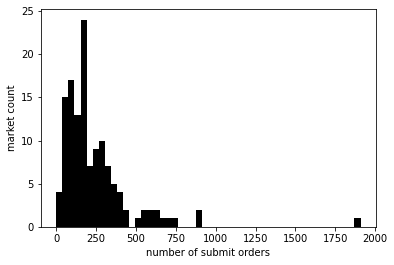

--------------------------------------------------


In [ ]:
ifp_liquid, ids_liquid = init()

In [ ]:
ids_liquid[:5]

['1040', '1047', '1051', '1053', '1056']

In [ ]:
df_ifp = pd.read_csv('/content/drive/MyDrive/IEOR4725 Prediction Market/data/ifps.csv', encoding='unicode_escape')
df_ord = pd.read_csv('/content/drive/MyDrive/IEOR4725 Prediction Market/data/pm_transactions.lum1.yr2.csv')

df_ifp['ifp_id'] = df_ifp['ifp_id'].apply(lambda x: x.split('-')[0])
df_ord['IFPID'] = df_ord['IFPID'].astype('str').apply(lambda x: x.split('.')[0])
df_ord['matching.order.ID'] = df_ord['matching.order.ID'].astype('str').apply(lambda x: x.split('.')[0])
df_ord['timestamp'] = pd.to_datetime(df_ord['timestamp'])

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/local/lib/python3.8/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [ ]:
df_ifp

,ifp_id,q_type,q_text,q_desc,q_status,date_start,date_suspend,date_to_close,date_closed,outcome,short_title,days_open,n_opts,options
0,1001,0,"Will the Six-Party talks (among the US, North ...",'In' refers to any time during the remainder o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/2/12,b,Six-party talks resume,123.0,2,"(a) Yes, (b) No"
1,1002,0,Who will be inaugurated as President of Russia...,'In' refers to any time during the 2012 calend...,closed,9/1/11,5/14/12 0:00,5/15/12,5/6/12,b,president of Russia,248.0,3,"(a) Medvedev, (b) Putin, (c) Neither"
2,1003,0,Will Serbia be officially granted EU candidacy...,A 'yes' answer to this question requires not o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/3/12,b,Serbia EU candidacy,124.0,2,"(a) Yes, (b) No"
3,1004,0,Will the United Nations General Assembly recog...,'By' means at or prior to the end of the day o...,closed,9/1/11,9/29/11 0:00,9/30/11,9/30/11,b,UN-GA recognize Palestine,29.0,2,"(a) Yes, (b) No"
4,1005,0,Will Daniel Ortega win another term as Preside...,If the Nicaraguan elections do not occur in la...,closed,9/1/11,11/4/11 0:00,11/5/11,11/5/11,a,Ortega win in Nicaragua,65.0,2,"(a) Yes, (b) No"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,5108,0,Will the Dow Jones Industrial Average daily cl...,Outcome will be determined based on reporting ...,voided,7/28/14,NaN,8/19/14,NaN,NaN,Dow Jones Closing Value,NaN,2,"(a) Yes, (b) No"
613,5109,0,Will Malaysia Airlines *officially file for ba...,Outcome will be determined by credible open so...,voided,7/28/14,NaN,8/20/14,NaN,NaN,Malaysia Airlines Bankruptcy,NaN,2,"(a) Yes, (b) No"
614,5110,6,How many games will the Boston Red Sox be out ...,The question will be resolved once the game is...,voided,7/28/14,NaN,8/19/14,NaN,NaN,Red Sox,NaN,4,"(a) 10 or more, (b) 9.5-7, (c) 6.5-4, (d) Less..."
615,6379,0,Will Yingluck Shinawatra vacate the office of ...,Yingluck Shinawatra will be considered to not ...,closed,3/12/14,4/30/14 9:00,4/30/14,4/30/14,b,Thailand: Shinawatra leaves office,49.0,2,"(a) Yes, (b) No"


In [ ]:
df_ord

,timestamp,IFPID,outcome,user.ID,Op.Type,order.ID,buy,long,with.MM,matching.order.ID,price,qty,experience,by.agent
0,2012-06-16 08:24:55,1040,a,6203,SubmitOrder,1.0,True,False,NaN,nan,40,2,1.0,NaN
1,2012-06-16 08:24:55,1040,a,6203,Trade,1.0,True,False,True,nan,45,1,1.0,NaN
2,2012-06-16 08:24:55,1040,a,6203,Trade,1.0,True,False,True,nan,40,1,1.0,NaN
3,2012-06-16 08:27:04,1089,a,6203,SubmitOrder,2.0,True,False,NaN,nan,40,2,1.0,NaN
4,2012-06-16 08:27:04,1089,a,6203,Trade,2.0,True,False,True,nan,45,1,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149442,2013-05-21 12:46:41,1138,a,1259,AgentHldgsXfer,NaN,NaN,NaN,NaN,nan,11,6,3.0,NaN
149443,2013-05-21 12:46:41,1138,a,1259,AgentDestroyed,NaN,NaN,NaN,NaN,nan,0,0,3.0,NaN
149444,2013-05-21 12:46:41,1138,a,460,AgentCashXfer,NaN,NaN,NaN,NaN,nan,69,1,2.0,NaN
149445,2013-05-21 12:46:41,1138,a,460,AgentHldgsXfer,NaN,NaN,NaN,NaN,nan,11,5,2.0,NaN


# Exploratory Data Analysis

In [ ]:
def market_summary(id):
    # summary of single market
    if id in ids_liquid:
        log = ifp_liquid[id]['market']['log']
        trade_log = ifp_liquid[id]['market']['trade_log']
        idx_buy = trade_log['buy_sell']
        idx_sell = ~idx_buy

        t0 = log['timestamp'].iloc[0]+pd.DateOffset(-1)
        t1 = log['timestamp'].iloc[-1]+pd.DateOffset(1)
        q = ifp_liquid[id]['short_title']
        mkt_agg = ifp_liquid[id]['market']['trade_agg']

        trade_cnt = ifp_liquid[id]['market']['trade_cnt']
        usr_ids = trade_cnt.sort_values().index[-5:]

        pnl = {'timestamp': mkt_agg.index}

        for usr in usr_ids:
            usr_log = trade_log[trade_log['user.ID']==usr]

            cash = list() # cash
            posn = list() # contract position
            mktv = list() # contract market value
            port = list() # portfolio value
            
            for t in mkt_agg.index:
                usr_log_t = usr_log[usr_log['timestamp']<=t]
                cash_t = -(usr_log_t['price']*usr_log_t['signed_qty']).sum()
                posn_t = usr_log_t['signed_qty'].sum()
                mktv_t = posn_t*mkt_agg.loc[t]['price']
                port_t = cash_t+mktv_t
                cash.append(cash_t)
                posn.append(posn_t)
                mktv.append(mktv_t)
                port.append(port_t)

            pnl[usr] = port

        pnl = pd.DataFrame(pnl)
        # print(pnl)

        pnl_T = dict()

        for usr in ifp_liquid[id]['market']['usr_ids']:
            usr_log = trade_log[trade_log['user.ID']==usr]
            cash_T = -(usr_log['price']*usr_log['signed_qty']).sum()
            posn_T = usr_log['signed_qty'].sum()
            mktv_T = posn_T*mkt_agg.iloc[-1]['price']
            port_T = cash_T+mktv_T
            pnl_T[usr] = port_T

        pnl_T = pd.Series(pnl_T)
        # print(pnl_T)

        print('-'*50)
        print('id:          ', id)
        print('q_text:      ', ifp_liquid[id]['q_text'])
        print('date_start:  ', ifp_liquid[id]['date_start'])
        print('date_suspend:', ifp_liquid[id]['date_suspend'])
        print('outcome:     ', ifp_liquid[id]['outcome'])
        print('n_traders:   ', len(ifp_liquid[id]['market']['usr_ids']))
        print('n_orders:    ', ifp_liquid[id]['market']['n_orders'])
        print('n_trades:    ', ifp_liquid[id]['market']['n_trades'])
        print('n_buys:      ', sum(idx_buy))
        print('n_sells:     ', sum(idx_sell))
        print('-'*50)

        fig, ax1 = plt.subplots(figsize=(16,4))
        ax1.scatter(trade_log[idx_buy]['timestamp'], trade_log[idx_buy]['price'], s=15, c='g', marker='^', label='buy')
        ax1.scatter(trade_log[idx_sell]['timestamp'], trade_log[idx_sell]['price'], s=15, c='r', marker='v', label='sell')
        ax1.plot(mkt_agg.index, mkt_agg['price'], 'k', lw=1, label='avg price')
        ax2 = ax1.twinx()
        ax2.bar(mkt_agg.index, mkt_agg['qty'], color='k', width=0.5, alpha=0.2, label='volume')
        ax1.set_title(f'Prediction market {id} on "{q}"\nTrades from {t0.date()} to {t1.date()}')
        ax1.set_xlim(t0,t1)
        ax1.set_ylim(0,100)
        ax1.set_ylabel('trade price')
        ax2.set_ylabel('volume')
        ax1.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        for usr in usr_ids:
            plt.plot(pnl['timestamp'], pnl[usr], lw=1, label=f'id={usr} ({trade_cnt[usr]})')
        plt.title(f'Prediction market {id} on "{q}"\nP&Ls of top {len(usr_ids)} frequent traders')
        # plt.xticks(rotation=30)
        plt.xlim(t0,t1)
        plt.ylabel('P&L')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(6,4))
        plt.hist(pnl_T, bins=50, color='k')
        plt.title(f'Prediction market {id} on "{q}"\nP&L histogram of all traders')
        plt.xlabel('P&L')
        plt.ylabel('trader count')
        plt.show()

--------------------------------------------------
id:           1056
q_text:       Will 1 Euro buy less than $1.20 US dollars at any point before 1 January 2013? 
date_start:   1/9/12
date_suspend: 12/30/12 0:00
outcome:      b
n_traders:    164
n_orders:     897
n_trades:     1152
n_buys:       573
n_sells:      579
--------------------------------------------------


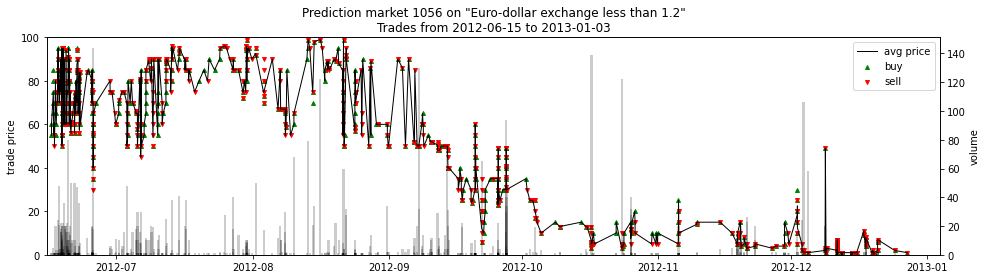

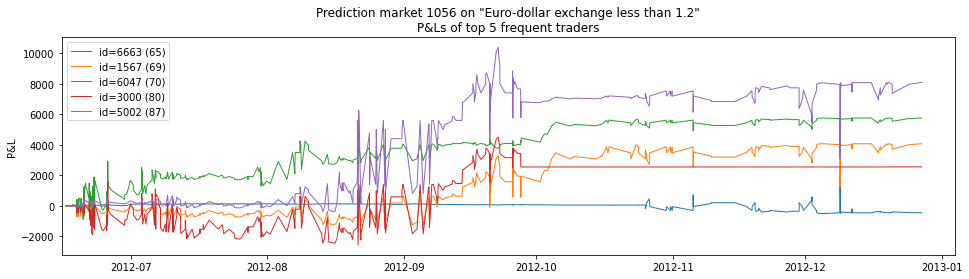

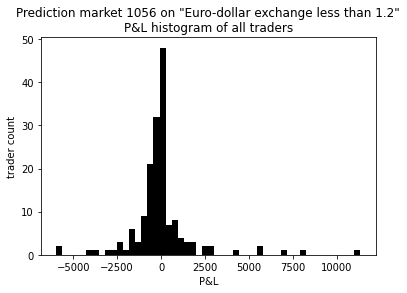

In [ ]:
market_summary('1056')

In [ ]:
def ifp_liquid_summary(mkts=ifp_liquid, plot=True):
    # summary of all markets
    ifp_usr = {id: mkts[id]['market']['usr_ids'] for id in mkts}
    all_usr = np.unique(np.concatenate(list(ifp_usr.values())))
    ifp_usr = {id: np.in1d(all_usr, ifp_usr[id]) for id in mkts}
    usr_mtrx = np.vstack(list(ifp_usr.values()))

    cum_pnl = {usr: 0 for usr in all_usr}
    usr_mkt = {usr: list() for usr in all_usr}

    for id in mkts:
        trade_log = mkts[id]['market']['trade_log']
        mkt_agg = mkts[id]['market']['trade_agg']
        for usr in mkts[id]['market']['usr_ids']:
            usr_log = trade_log[trade_log['user.ID']==usr]
            cash_T = -(usr_log['price']*usr_log['signed_qty']).sum()
            posn_T = usr_log['signed_qty'].sum()
            mktv_T = posn_T*mkt_agg.iloc[-1]['price']
            port_T = cash_T+mktv_T
            cum_pnl[usr] += port_T
            usr_mkt[usr].append(id)

    avg_pnl = {usr: cum_pnl[usr]/len(usr_mkt[usr]) for usr in all_usr}
    avg_pnl = pd.Series(avg_pnl)
    cum_pnl = pd.Series(cum_pnl)

    if plot:
        fig = plt.figure(figsize=(8,6))
        plt.imshow(usr_mtrx, cmap='binary')
        plt.title('Participation of active traders')
        plt.xlabel('trader index')
        plt.ylabel('market')
        plt.xticks([])
        plt.yticks([])
        plt.show()

        fig = plt.figure(figsize=(6,4))
        plt.hist(avg_pnl, bins=50, color='k')
        plt.axvline(x=avg_pnl.mean(), c='r', ls='--', label='$\mu$')
        plt.axvline(x=avg_pnl.mean()+avg_pnl.std(), c='b', ls='--', label='$\mu\pm\sigma$')
        plt.axvline(x=avg_pnl.mean()-avg_pnl.std(), c='b', ls='--')
        plt.title('Cumulative P&L (per market) histogram of all traders')
        plt.xlabel('P&L')
        plt.ylabel('trader count')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(6,4))
        plt.hist(cum_pnl, bins=50, color='k')
        plt.title('Cumulative P&L histogram of all traders')
        plt.xlabel('P&L')
        plt.ylabel('trader count')
        plt.show()

        fig = plt.figure(figsize=(6,4))
        plt.scatter(np.arange(len(cum_pnl)), cum_pnl.sort_values(), c='k', s=5)
        plt.axhline(y=0, c='k', ls='--')
        plt.title('Cumulative P&Ls of all traders')
        plt.xlabel('trader index')
        plt.ylabel('sorted P&L')
        plt.xticks([])
        plt.show()

    return avg_pnl, cum_pnl

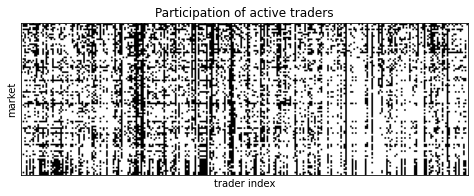

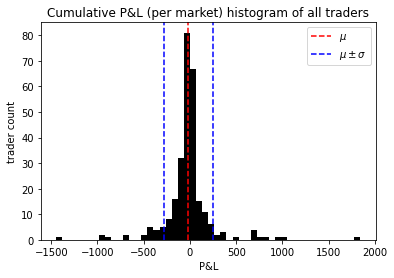

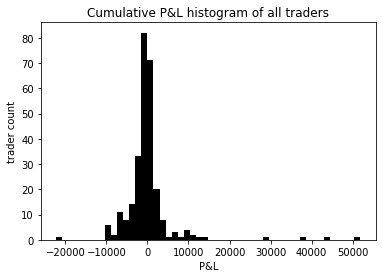

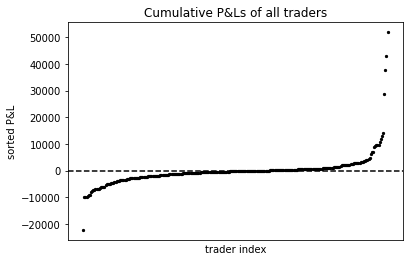

(1          0.000000
 20       482.650000
 315      -60.741935
 323     -117.100000
 373       55.424000
             ...    
 6824      -9.714286
 6826    -487.400000
 6833    -371.120000
 6850      13.259259
 20030      0.000000
 Length: 273, dtype: float64, 1           0.0
 20       9653.0
 315     -1883.0
 323     -2927.5
 373      1385.6
           ...  
 6824     -136.0
 6826    -4874.0
 6833    -9278.0
 6850      358.0
 20030       0.0
 Length: 273, dtype: float64)

In [ ]:
ifp_liquid_summary()

# Contribution Weighted Model

Algorithm (Ideas):

1. Identify positively contributing traders based on their cumulative P&Ls (profits) in `train` markets. These traders are deemed "better informed" as they perform (i.e. positive P&Ls) in the long run.
1. Contribution weights `w` of traders correlate with their historical profits, with losing traders discarded. `w` is normalized s.t. it sums to unity.
1. Simulate trading in `test` markets by keeping track of a time series of Beta-distributed belief `q(t)~Beta(α(t),β(t))`, updated according to buy/sell *submit* orders of contributing traders, whose beliefs are backed out of a *belief function* `q(price,demand,wealth,gamma)` under CRRA utility.
    * If mean of `q(t)` (our belief) deviates sufficiently from (market) traded price `p(t)`, enter into a position, e.g. if `q(t)>>p(t)`, buy certain amount of contracts according to a *demand function* `n(price,belief,wealth,gamma)`. The level of deviation may be quantified by s.d. of `q(t)`.
    * As submit orders of contributing traders flow in, update `α(t),β(t)`, and the mean and s.d. of the Beta-distributed belief `q(t)` vary accordingly.
    * How `α(t),β(t)` get updated depends on specific strategy, e.g. contribution weighted model updates according to contribution weights `w`, volume model updates according to `qty` of submit orders.

Algorithm (Details):

1. Compute cumulative $P\&L_i$ for each active trader $i$ in `train` market. Form the set of contributing traders $\{j:P\&L_j>0\}$ who yield positive cumulative P&Ls.
1. Contribution weight $w_j$ of contributing trader $j$ is calculated by $w_j=P\&L_j/\sum P\&L_j$, strictly positive.
1. Set up contribution weighted model based on defined parameters below, `W,G,C,K,T,P`.
1. With parameters `W,G`, impute beliefs of contributing traders based on their submit order flow. Denote $q_{jt}=\operatorname{belief}(p_t,n_t,W,G)$ as the belief of trader $j$ at time $t$, at which they submitted a buy/sell order.
1. Our belief of the binary event outcome is assumed to follow Beta-distribution $Beta(\alpha_t,\beta_t)$. As information (i.e. submit orders) flows in, $\alpha_t,\beta_t$ are updated accordingly. Specifically,
    * at inception, $\alpha_0=\beta_0=0$;
    * as submit order with imputed belief $q_{jt}$ flows in, update our belief distribution according to $\alpha_t=(1-Cw_j)\alpha_{t-1}+Cw_jq_{jt}$ and $\beta_t=(1-Cw_j)\beta_{t-1}+Cw_j(1-q_{jt})$, where $C<1/\max w_j$ is our `cwm` weight parameter;
    * our mean belief is given by $\hat{q}_t=\alpha_t/(\alpha_t+\beta_t)$ and s.d. is given by $\hat{\sigma}_t=\sqrt{\alpha_t\beta_t/(\alpha_t+\beta_t+1)}/(\alpha_t+\beta_t)$;
    * check that upon first submit order from trader $j$, our mean belief is exactly $q_{j1}$.
1. With our time series of mean belief $\hat{q}_t$ and s.d. $\hat{\sigma}_t$, we execute (simulate) our trades following rules below:
    * we trade at time $t$ only when some trades by other participants happen at time $t$;
    * suppose that at time $t$, trades occur at average price $p_t$ with volume $v_t$, and $p_t$ is the price we trade at should we submit an order;
    * compute a normalized trading signal $s_t=(p_t-\hat{q}_t)/\hat{\sigma}_t$ and a temporary demand $n_t=\operatorname{demand}(p_t,\hat{q}_t,W,G)$;
    * we require that (1) $n_t$ is rounded to an integer, (2) the absolute magnitude of $n_t$ cannot exceed half of trading volume at time $t$, and (3) after trading $n_t$, our position size does not fall outside the bound $[-P,P]$ -- this prevents frequent trading as we stop over-sizing as the bound is reached;
    * with trigger level $K$, if $s_t<-K$ or $s_t>K$, we execute a trade at price $p_t$ with signed quantity $n_t$, appropriately updating the cash position, with transaction cost $T|n_tp_t|$;
    * the above procedure repeats, and cash, position etc. information is kept track of until the termination of market;
    * at termination (the last trade), we obtain a cumulative P&L under strategy `cwm` for a specific market under parameters `W,G,C,K,T,P`.
1. Remark: This is effectively a mean-reversion trading strategy, with the mean backed out of a Beta-distributed belief, expecting that traded price from noisy traders oscillates around the mean, which we take advantage of.

Assumptions:

1. We know the *complete order flow* with trader information e.g. `id` -- this is very unrealistic but that is what data provide to us. More realistically, we know only traded price and volume information. See benchmark strategies below.
1. As we submit an order, it immediately gets executed at the average price at the next trading instance.
1. Price slippage is summarized by transaction cost parameter $T$.
1. We can take on short position on contracts with position size limit $[-P,P]$.

Belief and Demand Function: Assuming CRRA utility,

1. $\operatorname{belief}(p,n,W,G) = p \cdot b/(1+p(b-1))$ where $b=[1+n/(W-np)]^G$
1. $\operatorname{demand}(p,q,W,G) = W \cdot (a-1)/(1+p(a-1))$ where $a=[q(1-p)/p(1-q)]^{1/G}$
1. Remark: see lecture slides L2

Parameters:

1. `W`: wealth of each trader e.g. `1000`; this is just a parameter in belief/demand function, and will not constrain one's trading in any way
1. `G`: risk aversion parameter, gamma, under CRRA utility e.g. `2`; again, just a parameter in belief/demand function
1. `C`: weight parameter of `cwm` e.g. `2`; larger `C` means new order flow information is more emphasized
1. `K`: trigger level of trading signal e.g. `0.5`; smaller `K` means trading signal is more easily triggered
1. `T`: transaction cost percentage e.g. `0.05`
1. `P`: position constraint s.t. `-P<=posn<=P` e.g. `500`

Implied Parameters from Training:

1. By backtesting (optimizing) a strategy in `train` markets, we can imply parameters `W,G,C,K`. My experience is that strategy P&L is most sensitive to `C,K`, so maybe we can first fix `W=1000,G=2` and optimize `C,K`, then fine-tune `W,G`. Optimization over continuous space is impractical (too slow) and unnecessary (e.g. `G` is never precise) so we adopt grid search, over `C=0.1,0.2,...,0.5,1,...,3` and `K=0,0.1,...,1`.
1. Parameters `T,P` are set according to market natures/rules. For simplicity, we assume `T=0.05,P=500`. `T` is intentionally set large to avoid underestimation of price slippage, as prediction market is not liquid.
1. We do not train over all markets in `train_ids` as this is too time-consuming. Instead, we train over the single most liquid market, top 5 liquid markets, top 10 liquid markets etc. until we observe convergence.
1. Mathematically, optimal parameters $C^*,K^* = \operatorname{argmax}_{C,K} \frac{1}{N} \sum_{i=1}^{N} \operatorname{strategyP\&L}_i(W=1000,G=2,C,K)$, where $N$ is the number of markets used in training. Then, $W^*,G^* = \operatorname{argmax}_{W,G} \frac{1}{N} \sum_{i=1}^{N} \operatorname{strategyP\&L}_i(W,G,C^*,K^*)$. Optionally, we may optimize position limit $P$.

Other Benchmark Strategies: Here we do not update according to traders' cumulative P&Ls; instead, we consider the following strategies.

1. *Volume weighting of all submit order flows*: choose belief update weight $w_t=\min(v_t/\max_{t' \leq t}v_{t'},w)$, say $w=0.5$, where $v_t$ is traded volume at time $t$.
1. *Equal weighting of all submit order flows*: choose belief update weight $w_t=w$, say $w=0.05$.
1. *Herd trading of contributing traders*: once we observe the submit order of trader $j$ at time $t$, we trade with his belief $q_{jt}$ at the next traded price at probability $p_j=\min(w_j/\max w_j,p)$, say $p=0.8$.

Functions:

1. `belief(price, demand, W, G)`: belief function depending on `price` and `demand`
1. `demand(price, belief, W, G)`: demand function depending on `price` and `belief`
1. `get_weight(ids)`: get weight for contribution weighted model from cumulative P&Ls of traders
1. `trade_market_cwm(id, weight, W, G, ...)`: simulate trading in market `id` based on contribution weighted model `cwm`
1. `trade_market_vol(id, W, G, ...)`: simulate trading in market `id` based on volume weighting of all submit order flows
1. `trade_market_eq(id, W, G, ...)`: simulate trading in market `id` based on equal weighting of all submit order flows
1. `trade_market_herd(id, W, G, ...)`: simulate trading in market `id` based on herd trading of contributing traders
1. `trade_market_rand(id, W, G, ...)`: simulate trading in market `id` based on random decisions (as control)
1. `backtest(ids, strat, **kwargs)`: backtest `strat` in markets `ids` with parameters `**kwargs`

## Contribution Weights

In [ ]:
def get_weight(ids):
    ifp_usr = {id: ifp_liquid[id]['market']['usr_ids'] for id in ifp_liquid}
    all_usr = np.unique(np.concatenate(list(ifp_usr.values())))
    cum_pnl = {usr: 0 for usr in all_usr}

    for id in tqdm(ids):
        trade_log = ifp_liquid[id]['market']['trade_log']
        mkt_agg = ifp_liquid[id]['market']['trade_agg']
        for usr in ifp_liquid[id]['market']['usr_ids']:
            usr_log = trade_log[trade_log['user.ID']==usr]
            cash_T = -(usr_log['price']*usr_log['signed_qty']).sum()
            posn_T = usr_log['signed_qty'].sum()
            mktv_T = posn_T*mkt_agg.iloc[-1]['price']
            port_T = cash_T+mktv_T
            cum_pnl[usr] += port_T

    cum_pnl = pd.Series(cum_pnl)
    w = cum_pnl[cum_pnl>0]
    w /= w.sum()

    print()
    print('% contributing traders:', 100*len(w)/len(all_usr))
    
    return w

## Train & Test Markets

In [ ]:
n_train = round(len(ids_liquid)*.6)
train_ids = ids_liquid[:n_train] # train markets
test_ids = ids_liquid[-n_train:] # test markets
weight = get_weight(train_ids) # trader contributions

100%|██████████| 56/56 [00:03<00:00, 14.36it/s]


% contributing traders: 41.75824175824176


In [ ]:
train_ids[:5], test_ids[:5]

(['1040', '1047', '1051', '1053', '1056'],
 ['1140', '1142', '1143', '1144', '1145'])

## Trading Strategies

In [ ]:
def belief(price, demand, W, G):
    p = price
    n = demand
    b = (1+n/(W-n*p))**G
    q = p*b/(1+p*(b-1))
    return q

def demand(price, belief, W, G):
    p = price
    q = belief
    a = ((q*(1-p))/(p*(1-q)))**(1/G)
    n = W*(a-1)/(1+p*(a-1))
    return n

In [ ]:
def trade_market_cwm(id, weight, W, G, C, K=0.5, T=0, P=None, plot=False):
    # simulate trading in market id based on contribution weighted model
    if not P: P = np.Inf

    log = ifp_liquid[id]['market']['log']
    order_log = ifp_liquid[id]['market']['order_log'].copy()
    trade_log = ifp_liquid[id]['market']['trade_log']
    mkt_agg = ifp_liquid[id]['market']['trade_agg']

    t0 = log['timestamp'].iloc[0]+pd.DateOffset(-1)
    t1 = log['timestamp'].iloc[-1]+pd.DateOffset(1)
    q = ifp_liquid[id]['short_title']

    idx_buy = trade_log['buy_sell']
    idx_sell = ~idx_buy
    
    # construct time series of belief based on submit order flow
    order_log['belief'] = belief(order_log['price']/100, order_log['signed_qty'], W, G)
    order_log['weight'] = order_log['user.ID'].apply(lambda x: weight[x] if x in weight else 0)
    
    a = list() # alpha of Beta-distributed belief
    b = list() # beta of Beta-distributed belief
    for i, row in order_log.reset_index().iterrows():
        w = C * row['weight']
        if i == 0:
            a.append(w*row['belief'])
            b.append(w*(1-row['belief']))
        else:
            a.append((1-w)*a[i-1]+w*row['belief'])
            b.append((1-w)*b[i-1]+w*(1-row['belief']))
    order_log['alpha'] = a
    order_log['beta'] = b
    
    order_log['belief_mean'] = order_log['alpha']/(order_log['alpha']+order_log['beta'])
    order_log['belief_sd'] = np.sqrt((order_log['alpha']*order_log['beta'])/(order_log['alpha']+order_log['beta']+1))/(order_log['alpha']+order_log['beta'])
    # print(order_log)

    # simulate trading strategy
    cash = 0
    posn = 0
    mktv = 0
    port = 0
    pnl_ts = dict()

    for t, row in mkt_agg.iterrows():
        order_log_t = order_log[order_log['timestamp']<=t]
        
        p_t = row['price']/100
        v_t = row['qty']
        q_t = order_log_t['belief_mean'].iloc[-1]
        sd_t = order_log_t['belief_sd'].iloc[-1]
        s_t = (p_t-q_t)/sd_t

        n_t = demand(p_t, q_t, W/100, C)
        n_t = np.round(np.sign(n_t) * min(np.abs(n_t), v_t/2))
        n_t = max(min(n_t, P-posn), -P-posn)

        if s_t < -K or s_t > K:
            cash -= n_t*p_t + np.abs(n_t*p_t)*T
            posn += n_t
            mktv = posn*p_t
            port = cash+mktv
        else:
            n_t = 0

        pnl_ts[t] = {'n': n_t, 'cash': cash, 'posn': posn, 'mktv': mktv, 'port': port}

    pnl_ts = pd.DataFrame(pnl_ts).T

    sim = {
        'info': {
            'strat': 'cwm',
            'id': id,
            'W': W,
            'G': G,
            'C': C,
            'K': K,
            'T': T,
            'P': P,
        },
        'pnl': {
            'cash': cash,
            'posn': posn,
            'mktv': mktv,
            'port': port,
        },
        'pnl_ts': pnl_ts,
    }

    if plot:
        fig, ax1 = plt.subplots(figsize=(16,4))
        ax1.scatter(trade_log[idx_buy]['timestamp'], trade_log[idx_buy]['price'], s=15, c='g', marker='^', label='buy')
        ax1.scatter(trade_log[idx_sell]['timestamp'], trade_log[idx_sell]['price'], s=15, c='r', marker='v', label='sell')
        ax1.plot(order_log['timestamp'], 100*order_log['belief_mean'], 'b--', lw=2, label='cwm mean')
        plt.fill_between(order_log['timestamp'], 100*(order_log['belief_mean']-K*order_log['belief_sd']), 100*(order_log['belief_mean']+K*order_log['belief_sd']), color='b', alpha=0.2)
        ax1.plot(mkt_agg.index, mkt_agg['price'], 'k', lw=1, label='avg price')
        ax2 = ax1.twinx()
        ax2.bar(mkt_agg.index, mkt_agg['qty'], color='k', width=0.5, alpha=0.2)
        ax3 = ax1.twinx()
        ax3.plot(pnl_ts.index, pnl_ts['port'], 'k--', lw=2)
        ax3.scatter(pnl_ts[pnl_ts['n']>0].index, pnl_ts[pnl_ts['n']>0]['port'], s=40, c='k', marker='^')
        ax3.scatter(pnl_ts[pnl_ts['n']<0].index, pnl_ts[pnl_ts['n']<0]['port'], s=40, c='k', marker='v')
        ax1.set_title(f'Prediction market {id} on "{q}"\nContribution weighted model trading strategy')
        ax1.set_xlim(t0,t1)
        ax1.set_ylim(0,100)
        ax1.set_ylabel('trade price')
        ax3.set_ylabel('P&L')
        ax2.set_yticks([])
        ax1.legend()
        plt.show()

    return sim

In [ ]:
def trade_market_vol(id, W, G, C, K=0.5, T=0, P=None, wmax=0.5, plot=False):
    # simulate trading in market id based on volume weighting of all submit order flows
    if not P: P = np.Inf

    log = ifp_liquid[id]['market']['log']
    order_log = ifp_liquid[id]['market']['order_log'].copy()
    trade_log = ifp_liquid[id]['market']['trade_log']
    mkt_agg = ifp_liquid[id]['market']['trade_agg']

    t0 = log['timestamp'].iloc[0]+pd.DateOffset(-1)
    t1 = log['timestamp'].iloc[-1]+pd.DateOffset(1)
    q = ifp_liquid[id]['short_title']

    idx_buy = trade_log['buy_sell']
    idx_sell = ~idx_buy
    
    # construct time series of belief based on submit order flow
    order_log['belief'] = belief(order_log['price']/100, order_log['signed_qty'], W, G)
    order_log['weight'] = np.minimum(order_log['qty']/order_log['qty'].cummax(), wmax)
    
    a = list() # alpha of Beta-distributed belief
    b = list() # beta of Beta-distributed belief
    for i, row in order_log.reset_index().iterrows():
        w = C * row['weight']
        if i == 0:
            a.append(w*row['belief'])
            b.append(w*(1-row['belief']))
        else:
            a.append((1-w)*a[i-1]+w*row['belief'])
            b.append((1-w)*b[i-1]+w*(1-row['belief']))
    order_log['alpha'] = a
    order_log['beta'] = b
    
    order_log['belief_mean'] = order_log['alpha']/(order_log['alpha']+order_log['beta'])
    order_log['belief_sd'] = np.sqrt((order_log['alpha']*order_log['beta'])/(order_log['alpha']+order_log['beta']+1))/(order_log['alpha']+order_log['beta'])
    # print(order_log)

    # simulate trading strategy
    cash = 0
    posn = 0
    mktv = 0
    port = 0
    pnl_ts = dict()

    for t, row in mkt_agg.iterrows():
        order_log_t = order_log[order_log['timestamp']<=t]
        
        p_t = row['price']/100
        v_t = row['qty']
        q_t = order_log_t['belief_mean'].iloc[-1]
        sd_t = order_log_t['belief_sd'].iloc[-1]
        s_t = (p_t-q_t)/sd_t

        n_t = demand(p_t, q_t, W/100, C)
        n_t = np.round(np.sign(n_t) * min(np.abs(n_t), v_t/2))
        n_t = max(min(n_t, P-posn), -P-posn)

        if s_t < -K or s_t > K:
            cash -= n_t*p_t + np.abs(n_t*p_t)*T
            posn += n_t
            mktv = posn*p_t
            port = cash+mktv
        else:
            n_t = 0

        pnl_ts[t] = {'n': n_t, 'cash': cash, 'posn': posn, 'mktv': mktv, 'port': port}

    pnl_ts = pd.DataFrame(pnl_ts).T

    sim = {
        'info': {
            'strat': 'cwm',
            'id': id,
            'W': W,
            'G': G,
            'C': C,
            'K': K,
            'T': T,
            'P': P,
            'wmax': wmax,
        },
        'pnl': {
            'cash': cash,
            'posn': posn,
            'mktv': mktv,
            'port': port,
        },
        'pnl_ts': pnl_ts,
    }

    if plot:
        fig, ax1 = plt.subplots(figsize=(16,4))
        ax1.scatter(trade_log[idx_buy]['timestamp'], trade_log[idx_buy]['price'], s=15, c='g', marker='^', label='buy')
        ax1.scatter(trade_log[idx_sell]['timestamp'], trade_log[idx_sell]['price'], s=15, c='r', marker='v', label='sell')
        ax1.plot(order_log['timestamp'], 100*order_log['belief_mean'], 'b--', lw=2, label='cwm mean')
        plt.fill_between(order_log['timestamp'], 100*(order_log['belief_mean']-K*order_log['belief_sd']), 100*(order_log['belief_mean']+K*order_log['belief_sd']), color='b', alpha=0.2)
        ax1.plot(mkt_agg.index, mkt_agg['price'], 'k', lw=1, label='avg price')
        ax2 = ax1.twinx()
        ax2.bar(mkt_agg.index, mkt_agg['qty'], color='k', width=0.5, alpha=0.2)
        ax3 = ax1.twinx()
        ax3.plot(pnl_ts.index, pnl_ts['port'], 'k--', lw=2)
        ax3.scatter(pnl_ts[pnl_ts['n']>0].index, pnl_ts[pnl_ts['n']>0]['port'], s=40, c='k', marker='^')
        ax3.scatter(pnl_ts[pnl_ts['n']<0].index, pnl_ts[pnl_ts['n']<0]['port'], s=40, c='k', marker='v')
        ax1.set_title(f'Prediction market {id} on "{q}"\nVolume weighted model trading strategy')
        ax1.set_xlim(t0,t1)
        ax1.set_ylim(0,100)
        ax1.set_ylabel('trade price')
        ax3.set_ylabel('P&L')
        ax2.set_yticks([])
        ax1.legend()
        plt.show()

    return sim

In [ ]:
def trade_market_eq(id, W, G, C, K=0.5, T=0, P=None, w0=0.05, plot=False):
    # simulate trading in market id based on equal weighting of all submit order flows
    if not P: P = np.Inf

    log = ifp_liquid[id]['market']['log']
    order_log = ifp_liquid[id]['market']['order_log'].copy()
    trade_log = ifp_liquid[id]['market']['trade_log']
    mkt_agg = ifp_liquid[id]['market']['trade_agg']

    t0 = log['timestamp'].iloc[0]+pd.DateOffset(-1)
    t1 = log['timestamp'].iloc[-1]+pd.DateOffset(1)
    q = ifp_liquid[id]['short_title']

    idx_buy = trade_log['buy_sell']
    idx_sell = ~idx_buy
    
    # construct time series of belief based on submit order flow
    order_log['belief'] = belief(order_log['price']/100, order_log['signed_qty'], W, G)
    order_log['weight'] = w0
    
    a = list() # alpha of Beta-distributed belief
    b = list() # beta of Beta-distributed belief
    for i, row in order_log.reset_index().iterrows():
        w = C * row['weight']
        if i == 0:
            a.append(w*row['belief'])
            b.append(w*(1-row['belief']))
        else:
            a.append((1-w)*a[i-1]+w*row['belief'])
            b.append((1-w)*b[i-1]+w*(1-row['belief']))
    order_log['alpha'] = a
    order_log['beta'] = b
    
    order_log['belief_mean'] = order_log['alpha']/(order_log['alpha']+order_log['beta'])
    order_log['belief_sd'] = np.sqrt((order_log['alpha']*order_log['beta'])/(order_log['alpha']+order_log['beta']+1))/(order_log['alpha']+order_log['beta'])
    # print(order_log)

    # simulate trading strategy
    cash = 0
    posn = 0
    mktv = 0
    port = 0
    pnl_ts = dict()

    for t, row in mkt_agg.iterrows():
        order_log_t = order_log[order_log['timestamp']<=t]
        
        p_t = row['price']/100
        v_t = row['qty']
        q_t = order_log_t['belief_mean'].iloc[-1]
        sd_t = order_log_t['belief_sd'].iloc[-1]
        s_t = (p_t-q_t)/sd_t

        n_t = demand(p_t, q_t, W/100, C)
        n_t = np.round(np.sign(n_t) * min(np.abs(n_t), v_t/2))
        n_t = max(min(n_t, P-posn), -P-posn)

        if s_t < -K or s_t > K:
            cash -= n_t*p_t + np.abs(n_t*p_t)*T
            posn += n_t
            mktv = posn*p_t
            port = cash+mktv
        else:
            n_t = 0

        pnl_ts[t] = {'n': n_t, 'cash': cash, 'posn': posn, 'mktv': mktv, 'port': port}

    pnl_ts = pd.DataFrame(pnl_ts).T

    sim = {
        'info': {
            'strat': 'cwm',
            'id': id,
            'W': W,
            'G': G,
            'C': C,
            'K': K,
            'T': T,
            'P': P,
            'w0': w0,
        },
        'pnl': {
            'cash': cash,
            'posn': posn,
            'mktv': mktv,
            'port': port,
        },
        'pnl_ts': pnl_ts,
    }

    if plot:
        fig, ax1 = plt.subplots(figsize=(16,4))
        ax1.scatter(trade_log[idx_buy]['timestamp'], trade_log[idx_buy]['price'], s=15, c='g', marker='^', label='buy')
        ax1.scatter(trade_log[idx_sell]['timestamp'], trade_log[idx_sell]['price'], s=15, c='r', marker='v', label='sell')
        ax1.plot(order_log['timestamp'], 100*order_log['belief_mean'], 'b--', lw=2, label='cwm mean')
        plt.fill_between(order_log['timestamp'], 100*(order_log['belief_mean']-K*order_log['belief_sd']), 100*(order_log['belief_mean']+K*order_log['belief_sd']), color='b', alpha=0.2)
        ax1.plot(mkt_agg.index, mkt_agg['price'], 'k', lw=1, label='avg price')
        ax2 = ax1.twinx()
        ax2.bar(mkt_agg.index, mkt_agg['qty'], color='k', width=0.5, alpha=0.2)
        ax3 = ax1.twinx()
        ax3.plot(pnl_ts.index, pnl_ts['port'], 'k--', lw=2)
        ax3.scatter(pnl_ts[pnl_ts['n']>0].index, pnl_ts[pnl_ts['n']>0]['port'], s=40, c='k', marker='^')
        ax3.scatter(pnl_ts[pnl_ts['n']<0].index, pnl_ts[pnl_ts['n']<0]['port'], s=40, c='k', marker='v')
        ax1.set_title(f'Prediction market {id} on "{q}"\nEqually weighted model trading strategy')
        ax1.set_xlim(t0,t1)
        ax1.set_ylim(0,100)
        ax1.set_ylabel('trade price')
        ax3.set_ylabel('P&L')
        ax2.set_yticks([])
        ax1.legend()
        plt.show()

    return sim

In [ ]:
def trade_market_herd(id, weight, T=0, P=None, pmax=0.8, plot=False):
    # simulate trading in market id based on herd trading of contributing traders
    if not P: P = np.Inf

    log = ifp_liquid[id]['market']['log']
    order_log = ifp_liquid[id]['market']['order_log'].copy()
    trade_log = ifp_liquid[id]['market']['trade_log']
    mkt_agg = ifp_liquid[id]['market']['trade_agg']

    t0 = log['timestamp'].iloc[0]+pd.DateOffset(-1)
    t1 = log['timestamp'].iloc[-1]+pd.DateOffset(1)
    q = ifp_liquid[id]['short_title']

    idx_buy = trade_log['buy_sell']
    idx_sell = ~idx_buy

    order_log['weight'] = order_log['user.ID'].apply(lambda x: weight[x] if x in weight else 0)
    order_log['trade_prob'] = np.minimum(order_log['weight']/order_log['weight'].max(), pmax)
    order_log['unif_rv'] = np.random.uniform(size=len(order_log))

    # simulate trading strategy
    cash = 0
    posn = 0
    mktv = 0
    port = 0
    pnl_ts = dict()

    for t, row in mkt_agg.iterrows():
        order_log_t = order_log[order_log['timestamp']<=t]
        
        p_t = row['price']/100
        v_t = row['qty']

        n_t = order_log_t.iloc[-1]['signed_qty']
        n_t = np.round(np.sign(n_t) * min(np.abs(n_t), v_t/2))
        n_t = max(min(n_t, P-posn), -P-posn)

        if order_log_t.iloc[-1]['unif_rv'] < order_log_t.iloc[-1]['trade_prob']:
            cash -= n_t*p_t + np.abs(n_t*p_t)*T
            posn += n_t
            mktv = posn*p_t
            port = cash+mktv
        else:
            n_t = 0

        pnl_ts[t] = {'n': n_t, 'cash': cash, 'posn': posn, 'mktv': mktv, 'port': port}

    pnl_ts = pd.DataFrame(pnl_ts).T

    sim = {
        'info': {
            'strat': 'cwm',
            'id': id,
            'T': T,
            'P': P,
            'pmax': pmax,
        },
        'pnl': {
            'cash': cash,
            'posn': posn,
            'mktv': mktv,
            'port': port,
        },
        'pnl_ts': pnl_ts,
    }

    if plot:
        fig, ax1 = plt.subplots(figsize=(16,4))
        ax1.scatter(trade_log[idx_buy]['timestamp'], trade_log[idx_buy]['price'], s=15, c='g', marker='^', label='buy')
        ax1.scatter(trade_log[idx_sell]['timestamp'], trade_log[idx_sell]['price'], s=15, c='r', marker='v', label='sell')
        ax1.plot(mkt_agg.index, mkt_agg['price'], 'k', lw=1, label='avg price')
        ax2 = ax1.twinx()
        ax2.bar(mkt_agg.index, mkt_agg['qty'], color='k', width=0.5, alpha=0.2)
        ax3 = ax1.twinx()
        ax3.plot(pnl_ts.index, pnl_ts['port'], 'k--', lw=2)
        ax3.scatter(pnl_ts[pnl_ts['n']>0].index, pnl_ts[pnl_ts['n']>0]['port'], s=40, c='k', marker='^')
        ax3.scatter(pnl_ts[pnl_ts['n']<0].index, pnl_ts[pnl_ts['n']<0]['port'], s=40, c='k', marker='v')
        ax1.set_title(f'Prediction market {id} on "{q}"\nHerd model trading strategy')
        ax1.set_xlim(t0,t1)
        ax1.set_ylim(0,100)
        ax1.set_ylabel('trade price')
        ax3.set_ylabel('P&L')
        ax2.set_yticks([])
        ax1.legend()
        plt.show()

    return sim

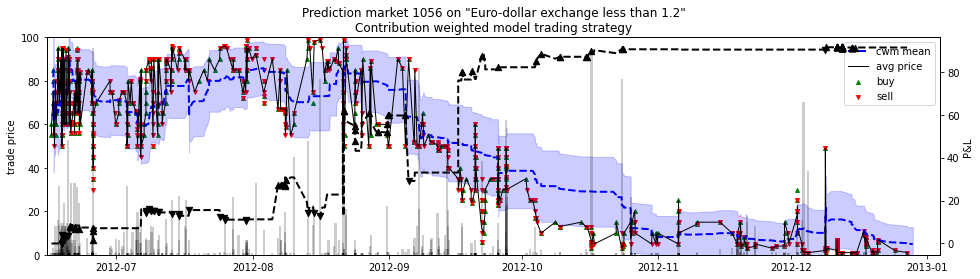

In [ ]:
sim = trade_market_cwm('1056', weight, W=1000, G=2, C=2, K=0.5, T=0.05, P=100, plot=True)

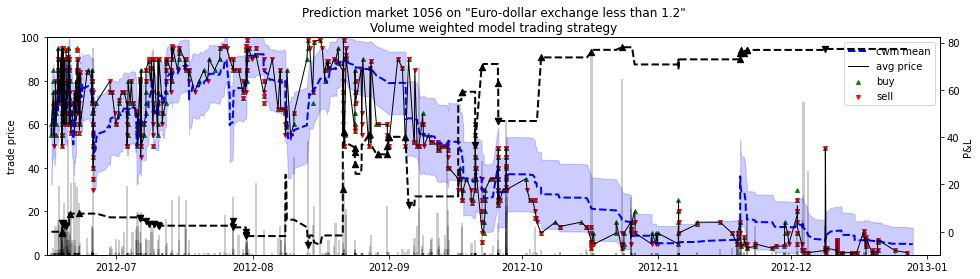

In [ ]:
sim = trade_market_vol('1056', W=1000, G=2, C=2, K=0.5, T=0.05, P=100, wmax=0.1, plot=True)

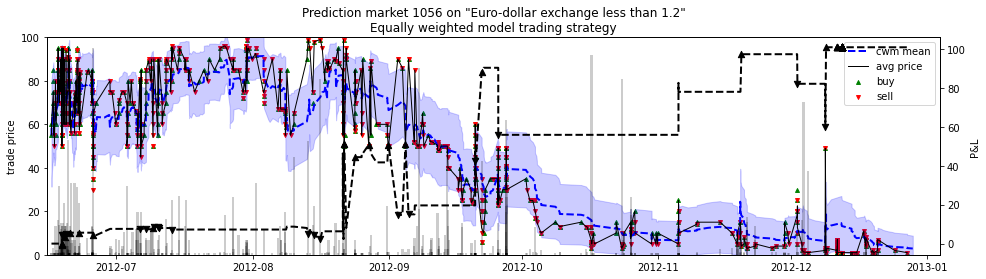

In [ ]:
sim = trade_market_eq('1056', W=1000, G=2, C=2, K=0.5, T=0.05, P=100, w0=0.05, plot=True)

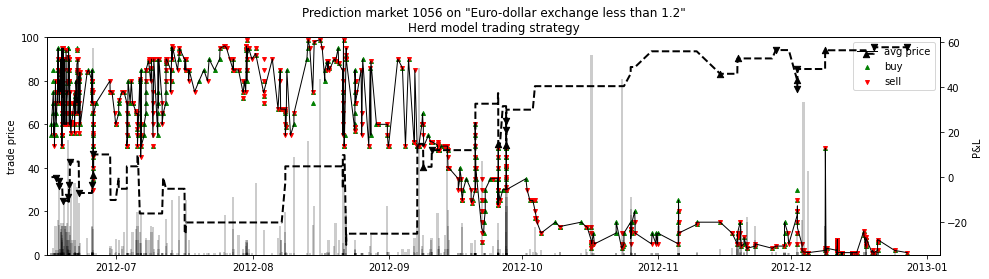

In [ ]:
sim = trade_market_herd('1056', weight, T=0.05, P=100, pmax=0.8, plot=True)

## Training for Optimal Parameters

Consider specifically training over top 5 and 10 liquid markets, for each strategy `cwm`, `vol`, `eq` and `herd`, where

* for `cwm`, we first optimize over `C,K` then `W,G`
* for `vol`, we first optimize `wmax`, then `C,K`, finally `W,G`
* for `eq`, we first optimize `w0`, then `C,K`, finally `W,G`
* for `herd`, we optimize `wmax`

Recall that `C,K` relate to trading strategy while `W,G` relate to belief calculation. Thus, intuitively P&L is most sensitive to `C,K` and less to `W,G`.

In [ ]:
n_orders = pd.Series({id: ifp_liquid[id]['market']['n_orders'] for id in train_ids})
train_ids_top1 = n_orders.sort_values()[-1:].index.to_list()
train_ids_top5 = n_orders.sort_values()[-5:].index.to_list()
train_ids_top10 = n_orders.sort_values()[-10:].index.to_list()
train_ids_top15 = n_orders.sort_values()[-15:].index.to_list()
print(train_ids_top10)

['1165', '1105', '1098', '1128', '1095', '1114', '1109', '1051', '1159', '1056']


In [ ]:
def backtest(ids, strat, **kwargs):
    if strat == 'cwm':
        trade = trade_market_cwm
    elif strat == 'vol':
        trade = trade_market_vol
    elif strat == 'eq':
        trade = trade_market_eq
    elif strat == 'herd':
        trade = trade_market_herd
    else:
        return
    sims = dict()
    for id in ids:
        sim = trade(id, **kwargs)
        sims[id] = sim
    return sims

In [ ]:
def pnl_grid_over_CK(ids, strat, CC=None, KK=None, **kwargs):
    # simulate P&Ls over C,K-grid
    if CC is None or KK is None:
        CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
        KK = np.arange(0.0,1.1,0.1)
    N = len(CC)*len(KK)
    pnls = dict()
    with tqdm(total=N, position=0, leave=True) as pbar:
        for C in CC:
            pnls[C] = dict()
            for K in KK:
                sims = backtest(ids, strat, C=C, K=K, **kwargs)
                pnls[C][K] = np.mean([sims[id]['pnl']['port'] for id in sims])
                pbar.update()
    pnls = pd.DataFrame(pnls)
    return pnls

In [ ]:
def pnl_grid_over_WG(ids, strat, WW=None, GG=None, **kwargs):
    # simulate P&Ls over W,G-grid
    if WW is None or GG is None:
        WW = np.arange(1000,11000,1000)
        GG = np.arange(0.5,8.5,0.5)
    N = len(WW)*len(GG)
    pnls = dict()
    with tqdm(total=N, position=0, leave=True) as pbar:
        for W in WW:
            pnls[W] = dict()
            for G in GG:
                sims = backtest(ids, strat, W=W, G=G, **kwargs)
                pnls[W][G] = np.mean([sims[id]['pnl']['port'] for id in sims])
                pbar.update()
    pnls = pd.DataFrame(pnls)
    return pnls

In [ ]:
def pnl_grid_over_P(ids, strat, param, PP, **kwargs):
    # simulate P&Ls over P-grid, where P is some user-specified param
    N = len(PP)
    pnls = dict()
    with tqdm(total=N, position=0, leave=True) as pbar:
        for P in PP:
            kwargs[param] = P
            sims = backtest(ids, strat, **kwargs)
            pnls[P] = np.mean([sims[id]['pnl']['port'] for id in sims])
            pbar.update()
    pnls = pd.Series(pnls)
    return pnls

In [ ]:
def plot_3d_surf(x, y, df, xlabel=None, ylabel=None, zlabel=None, title=None, **kwargs):
    X,Y = np.meshgrid(x,y)
    Z = df.to_numpy()
    D = pd.DataFrame(np.array([X,Y,Z]).reshape(3,-1).T,columns=['X','Y','Z'])
    
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection="3d")
    surf = ax.plot_trisurf(D['X'],D['Y'],D['Z'],cmap='copper')
    fig.subplots_adjust(left=0,right=0.9,bottom=0,top=1)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if zlabel: ax.set_zlabel(zlabel)
    if title: ax.set_title(title)
    plt.show()

### `cwm`

* Top 5 liquid markets: `C=1,K=0.1,W=5000,G=2`

* Top 10 liquid markets: `C=0.4,K=0.3,W=1000,G=2`

In [ ]:
pnls_5_ck_cwm = pnl_grid_over_CK(train_ids_top5, 'cwm', weight=weight, W=1000, G=2, T=0.05, P=500, plot=False)
pnls_5_ck_cwm

100%|██████████| 110/110 [04:12<00:00,  2.29s/it]


,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0
0.0,123.376805,134.371215,138.116084,140.887965,144.199409,147.614248,133.116320,113.587611,96.039208,79.876421
0.1,123.038717,132.763187,138.233943,143.201747,144.100957,148.382949,131.050019,112.966962,95.551686,79.058291
0.2,123.018105,125.153316,126.423632,132.219863,138.166892,139.230778,121.142837,106.886258,89.801364,76.428287
0.3,110.328147,146.537041,149.967113,152.531128,143.782796,136.239799,117.293311,101.955232,87.299481,69.172668
0.4,103.882922,127.557946,135.890167,139.642566,137.966328,117.275986,102.286306,84.892375,68.234736,55.729362
0.5,68.149743,76.247130,91.658048,91.388765,97.943872,104.709377,86.348897,68.081101,52.863868,42.586944
0.6,42.428732,47.378130,55.144323,56.987701,72.061904,77.849737,58.822769,47.045686,40.860596,30.814268
0.7,27.220292,52.994399,46.098057,46.053526,75.801373,59.027262,47.332286,40.239657,32.077396,27.423613
0.8,11.174291,11.124738,23.131541,56.848086,53.353286,42.221054,35.249631,26.092220,22.805452,18.136378
0.9,5.660743,9.045643,10.733684,33.756786,31.619988,18.754508,11.762396,10.449271,13.043671,12.294405


In [ ]:
pnls_5_wg_cwm = pnl_grid_over_WG(train_ids_top5, 'cwm', weight=weight, C=1, K=0.1, T=0.05, P=500, plot=False)
pnls_5_wg_cwm

100%|██████████| 160/160 [06:11<00:00,  2.32s/it]


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
0.5,147.328805,150.067946,154.159227,156.535415,157.391103,156.524337,154.445585,153.099945,152.23641,152.126833
1.0,147.754105,149.860377,153.574227,156.600415,157.300103,156.617076,154.445585,153.099945,152.30141,152.126833
1.5,148.091840,149.865617,153.645627,156.123415,157.323203,156.509076,154.445585,153.099945,152.30141,152.126833
2.0,148.382949,150.278017,153.645627,156.324115,156.846203,155.931033,154.519485,153.099945,152.30141,152.126833
2.5,147.942649,150.383317,154.139127,156.395515,156.846203,155.931033,154.107485,153.099945,152.30141,152.126833
3.0,148.114179,150.721417,154.303127,156.395515,156.846203,155.862533,154.020685,152.715684,151.82441,152.126833
3.5,148.024812,150.617207,154.415366,156.835915,156.865603,155.862533,154.020685,152.715684,151.82441,151.649833
4.0,148.030712,150.866007,154.436262,156.835915,157.065603,155.862533,154.020685,152.715684,151.82441,151.714833
4.5,148.352712,150.865594,154.781062,156.751215,157.551892,155.862533,154.020685,152.715684,151.82441,151.714833
5.0,148.869598,150.761495,154.732662,156.770615,157.474936,156.356333,154.020685,152.715684,151.82441,151.807572


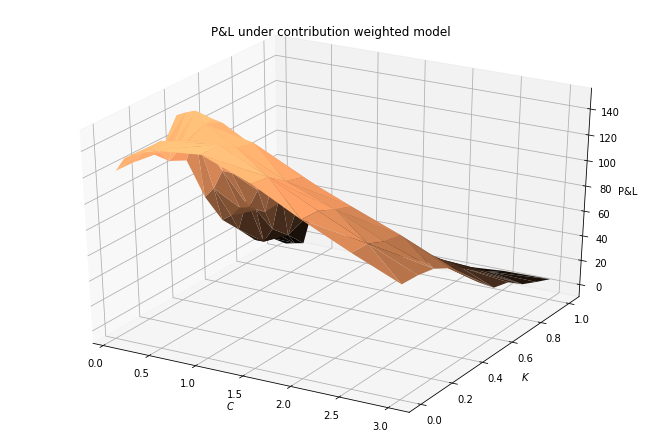

In [ ]:
CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
KK = np.arange(0.0,1.1,0.1)
plot_3d_surf(CC,KK,pnls_5_ck_cwm,'$C$','$K$','P&L','P&L under contribution weighted model')

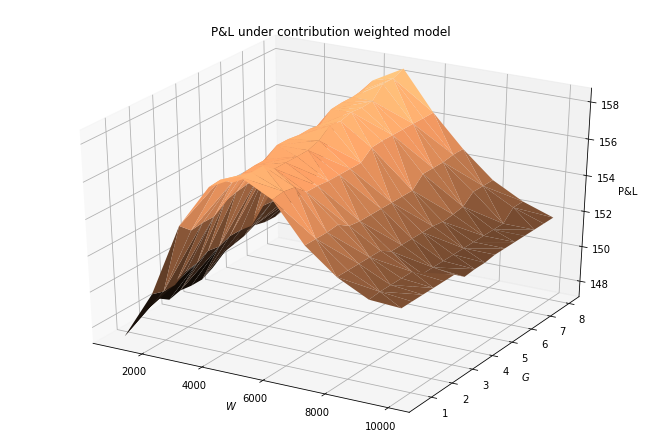

In [ ]:
WW = np.arange(1000,11000,1000)
GG = np.arange(0.5,8.5,0.5)
plot_3d_surf(WW,GG,pnls_5_wg_cwm,'$W$','$G$','P&L','P&L under contribution weighted model')

In [ ]:
pnls_10_ck_cwm = pnl_grid_over_CK(train_ids_top10, 'cwm', weight=weight, W=1000, G=2, T=0.05, P=500, plot=False)
pnls_10_ck_cwm

100%|██████████| 110/110 [12:10<00:00,  6.64s/it]


,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0
0.0,68.889904,75.598312,77.980626,79.243603,80.934112,82.360783,75.786867,64.882477,54.466400,45.562254
0.1,69.642345,75.725085,78.738384,80.837581,81.289325,83.678027,74.758043,65.117284,55.932339,46.625564
0.2,69.037808,71.027514,72.559198,74.828888,77.229820,80.330751,71.731484,65.177759,54.232556,46.219646
0.3,66.011558,84.935405,86.771541,88.566460,83.077033,80.800054,73.806260,63.357045,53.791067,43.304439
0.4,61.611877,74.869708,80.364918,82.628818,81.937124,75.796658,64.739971,55.422803,43.939926,35.914891
0.5,41.595593,47.046806,57.011766,58.137315,61.905428,68.744556,55.248947,44.328669,34.811709,28.683321
0.6,29.474513,33.762271,38.339392,39.180637,47.712189,50.776362,39.403237,31.134101,26.808248,21.173958
0.7,19.666173,35.225353,32.836158,33.131693,48.239366,39.353003,31.009271,26.170037,21.008898,16.542931
0.8,9.608871,11.641994,18.519496,36.538368,35.309218,28.584677,23.697418,18.217968,15.258676,11.551964
0.9,5.947221,9.849871,11.336367,23.280518,22.664419,15.467829,7.856025,6.863644,8.054811,7.697902


In [ ]:
pnls_10_wg_cwm = pnl_grid_over_WG(train_ids_top10, 'cwm', weight=weight, C=0.4, K=0.3, T=0.05, P=500, plot=False)
pnls_10_wg_cwm

100%|██████████| 160/160 [18:12<00:00,  6.83s/it]


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
0.5,87.143499,86.148868,84.849471,83.248040,82.930861,82.930861,82.930861,82.930861,82.930861,82.930861
1.0,87.395911,86.237368,84.849471,83.248040,82.930861,82.930861,82.930861,82.930861,82.930861,82.930861
1.5,87.784399,86.575238,84.897771,83.248040,82.930861,82.930861,82.930861,82.930861,82.930861,82.930861
2.0,88.566460,86.576813,84.912471,83.296340,82.930861,82.930861,82.930861,82.930861,82.930861,82.930861
2.5,88.590694,86.737438,85.230121,83.311040,82.979161,82.930861,82.930861,82.930861,82.930861,82.930861
3.0,88.047844,86.987088,85.230121,83.627115,82.993861,82.979161,82.930861,82.930861,82.930861,82.930861
3.5,87.923040,87.121569,85.504596,83.628690,83.389136,82.993861,82.979161,82.930861,82.930861,82.930861
4.0,88.040640,87.750649,85.403346,83.628690,83.311511,82.993861,82.993861,82.979161,82.930861,82.930861
4.5,87.857777,87.709021,85.647746,83.903690,83.311511,83.309936,82.993861,82.979161,82.979161,82.979161
5.0,87.369053,87.709021,85.825928,83.791415,83.311511,83.311511,83.389136,82.993861,82.979161,82.979161


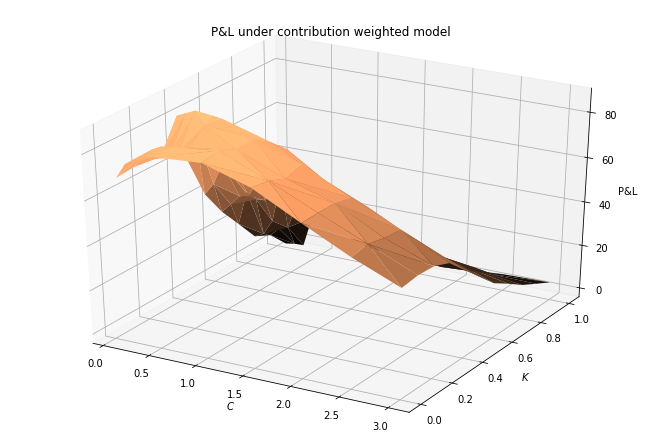

In [ ]:
CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
KK = np.arange(0.0,1.1,0.1)
plot_3d_surf(CC,KK,pnls_10_ck_cwm,'$C$','$K$','P&L','P&L under contribution weighted model')

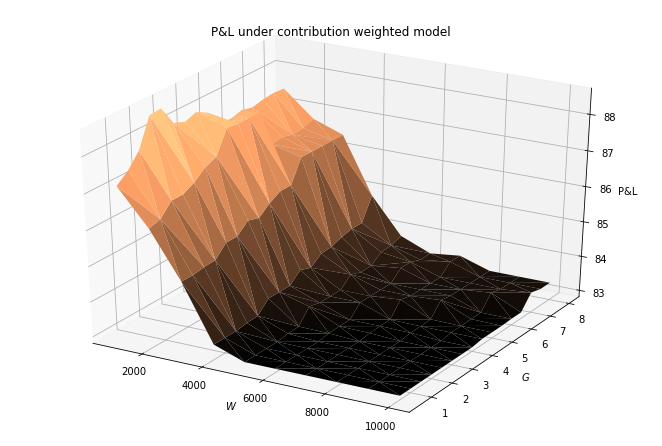

In [ ]:
WW = np.arange(1000,11000,1000)
GG = np.arange(0.5,8.5,0.5)
plot_3d_surf(WW,GG,pnls_10_wg_cwm,'$W$','$G$','P&L','P&L under contribution weighted model')

### `vol`

* Top 5 liquid markets: `wmax=0.25,C=0.5,K=0.1,W=4000,G=7`

* Top 10 liquid markets: `wmax=0.25,C=0.5,K=0.1,W=4000,G=7`

In [ ]:
pnls_5_wmax_vol = pnl_grid_over_P(train_ids_top5, 'vol', param='wmax', PP=np.arange(0.05,1.05,0.05), C=1, K=0.1, W=1000, G=2, T=0.05, P=500, plot=False)
pnls_5_wmax_vol

100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


0.05    122.291253
0.10    125.710979
0.15    134.767930
0.20    135.623872
0.25    138.002531
0.30    137.738779
0.35    134.179911
0.40    132.352476
0.45    132.207061
0.50    130.645007
0.55    131.561016
0.60    131.855203
0.65    131.212354
0.70    131.077557
0.75    129.968282
0.80    129.925549
0.85    129.424939
0.90    129.224164
0.95    128.855513
1.00    128.307893
dtype: float64

In [ ]:
pnls_5_ck_vol = pnl_grid_over_CK(train_ids_top5, 'vol', W=1000, G=2, T=0.05, P=500, wmax=0.25, plot=False)
pnls_5_ck_vol

100%|██████████| 110/110 [06:30<00:00,  3.55s/it]


,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0
0.0,99.595655,113.398343,128.871511,137.039079,139.085311,135.149307,110.759922,90.222488,71.389731,57.621267
0.1,107.751791,119.337724,133.715143,140.266127,142.949864,138.002531,112.332076,91.740089,63.515998,57.321434
0.2,102.499147,120.464382,129.330038,127.802038,130.246291,121.262330,104.741918,84.063519,67.549647,51.536455
0.3,98.894486,114.334602,115.551685,117.730176,119.135331,101.553342,79.379594,58.695660,55.164871,43.585450
0.4,92.165983,102.844706,102.101210,106.023688,100.810186,71.122005,57.786713,44.562246,31.294779,23.470767
0.5,79.127241,81.188930,89.384348,82.568118,75.549178,45.492927,29.451549,23.455124,16.377897,11.016587
0.6,69.926827,73.950354,72.587627,61.862604,72.714306,28.695405,25.934278,24.788842,22.055825,18.195313
0.7,52.389044,68.262330,79.726619,54.119199,43.373099,29.238427,18.136012,16.355627,13.934172,14.086115
0.8,30.902975,40.085526,40.081788,39.534185,29.807381,14.258906,14.590356,11.109227,11.865837,8.263315
0.9,5.827707,3.410000,21.595387,15.670487,7.690106,7.283952,9.186606,8.650456,8.624854,5.580035


In [ ]:
pnls_5_wg_vol = pnl_grid_over_WG(train_ids_top5, 'vol', C=0.5, K=0.1, T=0.05, P=500, wmax=0.25, plot=False)
pnls_5_wg_vol

100%|██████████| 160/160 [09:53<00:00,  3.71s/it]


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
0.5,142.271413,150.679805,153.067975,153.860597,153.501145,152.892936,151.852641,150.728661,149.863918,148.953338
1.0,142.685680,150.824368,153.137519,153.841197,153.524245,152.892936,151.833241,150.728661,149.839868,148.953338
1.5,142.829410,150.920380,153.092119,153.819497,153.595645,152.970282,151.833241,150.728661,149.839868,148.953338
2.0,142.949864,150.974924,153.082231,153.819497,153.550245,153.039420,151.924041,150.728661,149.839868,148.953338
2.5,143.101819,151.348824,153.058181,153.800097,153.550245,152.994020,151.904641,150.728361,149.930668,148.953338
3.0,143.463602,151.348824,153.057681,153.822197,153.530845,152.974620,151.936588,150.682961,149.930668,148.928988
3.5,143.467702,152.180424,153.549981,153.802797,153.524445,152.974620,151.893138,150.682961,149.885268,148.928988
4.0,143.757402,152.371037,153.606794,153.816297,153.505045,152.968220,151.893138,150.682961,149.885268,148.883588
4.5,143.122571,152.388437,153.709794,153.119947,153.505045,152.948820,151.873738,150.682961,149.885268,148.883588
5.0,142.760938,152.826312,154.699394,153.222947,153.476045,153.039920,151.867338,150.873195,149.885268,148.883588


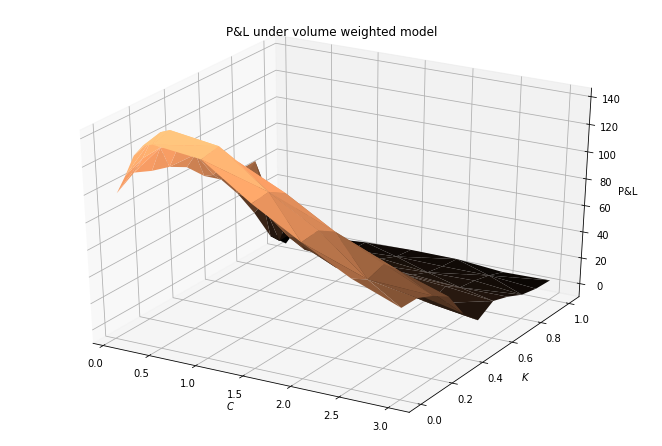

In [ ]:
CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
KK = np.arange(0.0,1.1,0.1)
plot_3d_surf(CC,KK,pnls_5_ck_vol,'$C$','$K$','P&L','P&L under volume weighted model')

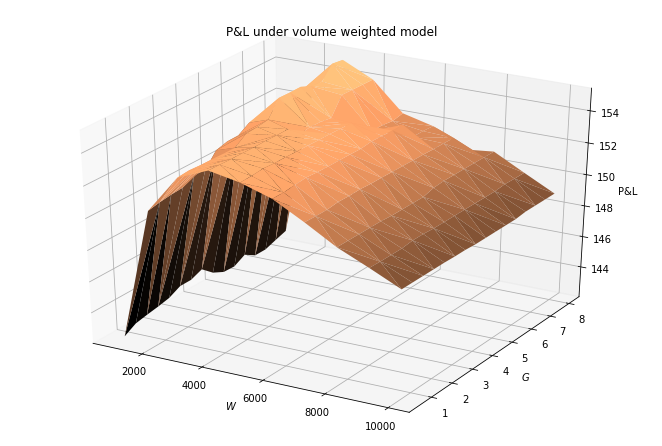

In [ ]:
WW = np.arange(1000,11000,1000)
GG = np.arange(0.5,8.5,0.5)
plot_3d_surf(WW,GG,pnls_5_wg_vol,'$W$','$G$','P&L','P&L under volume weighted model')

In [ ]:
pnls_10_wmax_vol = pnl_grid_over_P(train_ids_top10, 'vol', param='wmax', PP=np.arange(0.05,1.05,0.05), C=1, K=0.1, W=1000, G=2, T=0.05, P=500, plot=False)
pnls_10_wmax_vol

100%|██████████| 20/20 [02:00<00:00,  6.00s/it]


0.05    69.448070
0.10    67.758938
0.15    70.775761
0.20    70.846289
0.25    71.898094
0.30    71.479018
0.35    68.591254
0.40    67.012865
0.45    66.477587
0.50    65.538864
0.55    65.668929
0.60    65.525435
0.65    64.941221
0.70    64.778843
0.75    63.987505
0.80    64.090565
0.85    64.412554
0.90    63.914747
0.95    62.427279
1.00    62.069460
dtype: float64

In [ ]:
pnls_10_ck_vol = pnl_grid_over_CK(train_ids_top10, 'vol', W=1000, G=2, T=0.05, P=500, wmax=0.25, plot=False)
pnls_10_ck_vol

100%|██████████| 110/110 [10:40<00:00,  5.83s/it]


,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0
0.0,49.485327,59.082493,67.567838,69.723255,71.011766,68.965519,55.987197,43.972407,33.861261,26.459050
0.1,53.646091,62.702283,69.315908,73.330958,74.766600,71.898094,57.031477,45.337138,30.586051,27.390188
0.2,49.122131,60.140837,66.535570,66.071139,68.171528,64.763796,53.515675,41.978281,33.960303,25.527232
0.3,47.535049,57.614703,59.109768,61.396864,63.743142,54.885499,41.670573,30.243748,28.318018,20.920931
0.4,47.418152,55.003509,55.984989,58.353416,59.308214,39.662750,30.517854,23.807163,15.989502,11.990718
0.5,40.677848,43.495234,47.327843,44.263446,39.546226,25.130224,17.012666,12.258337,8.433620,5.595675
0.6,37.316085,40.144104,39.323450,33.248314,37.876133,15.192178,13.279764,12.317637,10.446929,8.060638
0.7,28.591847,36.686140,41.678885,29.144924,24.081174,15.329014,10.700981,9.903289,7.981111,7.733654
0.8,16.375512,21.222138,21.585069,21.030517,16.086615,7.983503,8.605153,6.477539,6.559294,4.516183
0.9,2.672553,2.192375,11.366818,8.571618,3.705628,3.631526,5.126803,4.739328,4.577627,3.132667


In [ ]:
pnls_10_wg_vol = pnl_grid_over_WG(train_ids_top10, 'vol', C=0.5, K=0.1, T=0.05, P=500, wmax=0.25, plot=False)
pnls_10_wg_vol

100%|██████████| 160/160 [16:28<00:00,  6.18s/it]


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
0.5,74.069769,80.563117,82.882454,83.679040,83.670900,83.423412,83.016758,82.533554,82.114038,81.705115
1.0,74.523384,80.854698,82.983826,83.731640,83.734200,83.475162,83.012308,82.533554,82.102013,81.705115
1.5,74.636198,80.956713,83.176626,83.753482,83.784950,83.524385,83.012308,82.516885,82.107263,81.710365
2.0,74.766600,81.168077,83.154964,83.927582,83.947850,83.580054,83.072758,82.516885,82.118855,81.710365
2.5,74.827702,81.362386,83.148189,83.923132,83.947850,83.726354,83.091250,82.531735,82.179255,81.710365
3.0,75.127473,81.372886,83.363189,83.939432,83.933023,83.716654,83.276223,82.525585,82.195805,81.713190
3.5,75.107532,81.825895,83.627839,83.929732,83.929823,83.721904,83.254498,82.694435,82.173105,81.729740
4.0,75.438501,81.991701,83.673086,84.151732,83.925373,83.718704,83.237779,82.694435,82.341955,81.875890
4.5,75.439486,81.943192,83.764786,83.808807,83.930623,83.760754,83.274579,82.711276,82.341955,81.875890
5.0,75.311485,82.242979,84.269936,83.906807,84.172623,83.817895,83.276629,82.806393,82.347205,81.875890


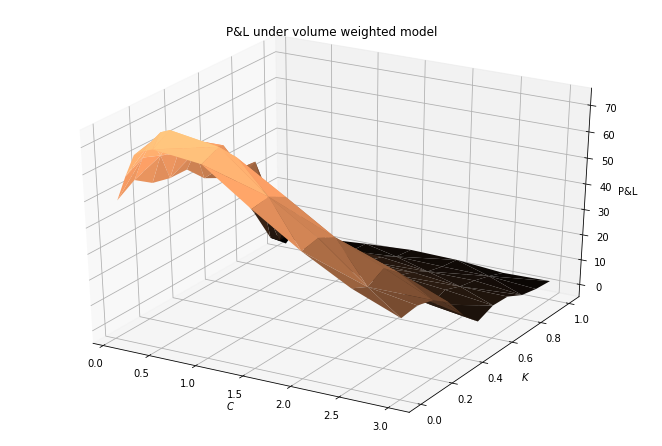

In [ ]:
CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
KK = np.arange(0.0,1.1,0.1)
plot_3d_surf(CC,KK,pnls_10_ck_vol,'$C$','$K$','P&L','P&L under volume weighted model')

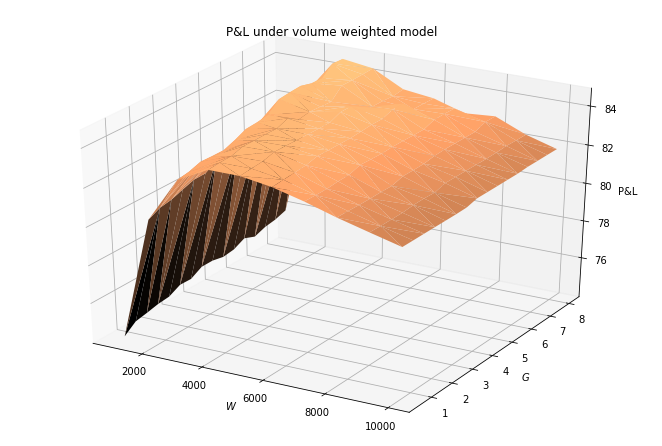

In [ ]:
WW = np.arange(1000,11000,1000)
GG = np.arange(0.5,8.5,0.5)
plot_3d_surf(WW,GG,pnls_10_wg_vol,'$W$','$G$','P&L','P&L under volume weighted model')

### `eq`

* Top 5 liquid markets: `w0=0.04,C=1,K=0.1,W=3000,G=2`

* Top 10 liquid markets: `w0=0.04,C=0.5,K=0.1,W=3000,G=2`

In [ ]:
pnls_5_w0_eq = pnl_grid_over_P(train_ids_top5, 'eq', param='w0', PP=np.arange(0.01,0.31,0.01), C=1, K=0.1, W=1000, G=2, T=0.05, P=500, plot=False)
pnls_5_w0_eq

100%|██████████| 30/30 [02:09<00:00,  4.31s/it]


0.01    113.666465
0.02    124.555811
0.03    125.995238
0.04    130.067269
0.05    127.711248
0.06    126.190690
0.07    124.297412
0.08    125.612040
0.09    124.477214
0.10    124.462066
0.11    124.772714
0.12    123.727218
0.13    123.239262
0.14    123.027927
0.15    121.522050
0.16    120.614980
0.17    118.006208
0.18    116.963921
0.19    115.229207
0.20    112.634160
0.21    111.706908
0.22    111.498541
0.23    109.099515
0.24    106.737851
0.25    107.007505
0.26    106.366866
0.27    104.201166
0.28    101.571568
0.29     98.973818
0.30     97.442856
dtype: float64

In [ ]:
pnls_5_ck_eq = pnl_grid_over_CK(train_ids_top5, 'eq', W=1000, G=2, T=0.05, P=500, w0=0.04, plot=False)
pnls_5_ck_eq

100%|██████████| 110/110 [06:54<00:00,  3.77s/it]


,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0
0.0,95.478671,102.708216,114.782579,120.954648,127.304844,128.589374,114.858735,100.322364,84.834928,68.826530
0.1,84.370489,104.180108,113.476463,121.642812,130.056239,130.067269,113.945096,99.979372,84.306658,69.155905
0.2,82.795944,87.843860,108.055110,118.610926,124.341601,117.020036,107.695993,95.564920,79.726024,65.497682
0.3,82.139124,87.077344,101.973911,111.375251,117.020043,114.517641,99.818971,81.004314,65.755709,53.821954
0.4,63.058360,80.555541,97.341165,100.379697,103.080522,91.737538,85.430385,73.219897,54.946187,44.362233
0.5,48.671193,60.091392,82.169493,90.419579,85.223506,84.486286,68.824604,54.549071,43.490316,31.443972
0.6,28.076228,61.277193,93.177269,83.427221,76.082182,53.949864,36.837314,27.557120,20.378337,15.616574
0.7,28.282817,42.787011,59.675652,53.529606,52.584412,35.376956,26.230514,18.969007,14.286069,10.341018
0.8,-2.613061,41.321431,44.265383,43.099940,33.125717,26.652600,18.461857,17.929825,13.041711,8.275026
0.9,3.654343,29.159215,39.576929,24.097954,19.444854,9.589377,18.040250,4.522495,3.497626,2.683877


In [ ]:
pnls_5_wg_eq = pnl_grid_over_WG(train_ids_top5, 'eq', C=1, K=0.1, T=0.05, P=500, w0=0.04, plot=False)
pnls_5_wg_eq

100%|██████████| 160/160 [09:57<00:00,  3.74s/it]


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
0.5,130.489687,136.828573,141.837818,141.705466,141.256227,140.638476,138.676466,137.069943,134.778584,133.295692
1.0,130.457687,136.828573,142.029388,141.635486,141.379427,140.638476,138.779466,137.069943,134.881584,133.295692
1.5,130.299569,136.641885,142.029388,141.488509,141.402527,140.638476,138.882466,137.069943,134.984584,133.295692
2.0,130.067269,136.551782,142.029388,141.488509,141.402527,140.638476,138.882466,137.069943,135.062031,133.295692
2.5,129.651114,136.654782,141.843088,141.488509,141.402527,140.638476,138.882466,137.069943,135.174918,133.295692
3.0,129.395314,136.578438,141.838888,141.461709,141.402527,140.638476,138.882466,137.069943,135.174918,133.295692
3.5,129.017152,136.404038,141.843088,141.461709,141.402527,140.638476,138.882466,137.069943,135.174918,133.295692
4.0,129.167252,136.589938,141.843088,141.466959,141.373871,140.413888,138.882466,137.069943,135.174918,133.295692
4.5,129.146152,136.698007,141.536970,141.457459,141.490340,140.387088,138.882466,137.069943,135.174918,133.295692
5.0,129.019264,136.698007,141.521170,141.457459,141.490340,140.442188,138.855666,137.069943,135.174918,133.295692


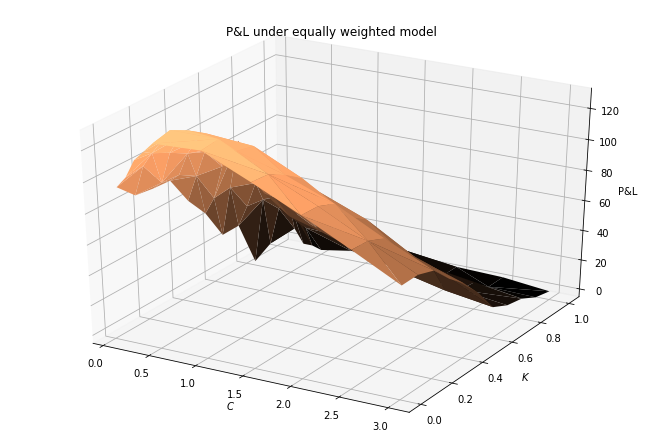

In [ ]:
CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
KK = np.arange(0.0,1.1,0.1)
plot_3d_surf(CC,KK,pnls_5_ck_eq,'$C$','$K$','P&L','P&L under equally weighted model')

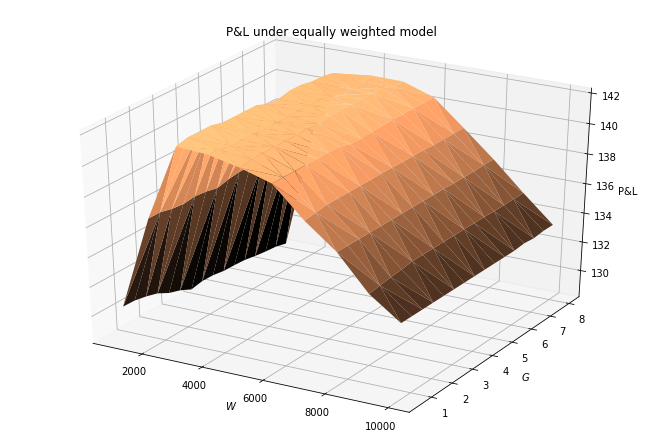

In [ ]:
WW = np.arange(1000,11000,1000)
GG = np.arange(0.5,8.5,0.5)
plot_3d_surf(WW,GG,pnls_5_wg_eq,'$W$','$G$','P&L','P&L under equally weighted model')

In [ ]:
pnls_10_w0_eq = pnl_grid_over_P(train_ids_top10, 'eq', param='w0', PP=np.arange(0.01,0.31,0.01), C=1, K=0.1, W=1000, G=2, T=0.05, P=500, plot=False)
pnls_10_w0_eq

100%|██████████| 30/30 [03:00<00:00,  6.01s/it]


0.01    58.481617
0.02    66.536655
0.03    70.127868
0.04    74.050072
0.05    73.107929
0.06    70.874042
0.07    70.183560
0.08    71.292261
0.09    70.511984
0.10    70.414479
0.11    69.987970
0.12    69.057735
0.13    68.273562
0.14    67.992872
0.15    66.914251
0.16    66.270396
0.17    64.993179
0.18    64.529826
0.19    63.635848
0.20    63.067147
0.21    62.636206
0.22    62.545556
0.23    61.725177
0.24    60.527672
0.25    60.531120
0.26    60.061475
0.27    59.077889
0.28    57.602429
0.29    56.210546
0.30    55.364217
dtype: float64

In [ ]:
pnls_10_ck_eq = pnl_grid_over_CK(train_ids_top10, 'eq', W=1000, G=2, T=0.05, P=500, w0=0.04, plot=False)
pnls_10_ck_eq

100%|██████████| 110/110 [10:55<00:00,  5.96s/it]


,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0
0.0,48.961166,54.177916,62.041377,65.649926,69.207433,71.372378,65.049374,56.591301,47.730259,38.692664
0.1,46.278756,57.264513,61.901326,65.807635,71.214266,74.050072,63.864192,56.346298,47.314347,38.448193
0.2,41.496242,45.313472,58.025724,64.139345,67.265509,65.626195,60.716476,54.062162,45.184711,37.363415
0.3,42.628377,46.347865,54.998067,60.266675,63.716859,68.719559,60.989405,48.358765,39.422433,31.915023
0.4,33.595154,47.821165,56.511322,59.004369,60.613465,55.278473,52.165391,44.300025,33.603889,26.720420
0.5,26.716164,34.188114,46.736018,52.538961,50.843170,51.857801,42.421726,33.779451,26.615883,19.931723
0.6,15.868239,34.731176,56.194868,51.393210,46.034641,35.533457,25.650307,18.327126,14.535294,11.649450
0.7,16.753652,24.184381,32.610201,30.154178,30.744931,22.180303,17.999082,13.605615,9.099132,6.746443
0.8,0.201920,22.887341,24.802016,24.690495,19.758433,16.950125,12.115853,11.065574,7.565603,4.997422
0.9,3.242121,16.698008,22.422815,14.474702,12.695452,8.449813,11.520550,2.818384,2.591636,1.702898


In [ ]:
pnls_10_wg_eq = pnl_grid_over_WG(train_ids_top10, 'eq', C=0.5, K=0.1, T=0.05, P=500, w0=0.04, plot=False)
pnls_10_wg_eq

100%|██████████| 160/160 [15:17<00:00,  5.73s/it]


,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
0.5,71.037821,72.944270,73.274616,72.199559,70.097615,69.141197,68.732417,68.477178,68.590345,68.714735
1.0,71.149799,72.944270,73.204372,72.178241,70.103915,69.141197,68.732417,68.477178,68.590345,68.714735
1.5,71.163816,72.992124,73.140113,72.178241,70.141856,69.147497,68.738717,68.483478,68.590345,68.714735
2.0,71.214266,72.918635,73.145213,72.178241,70.141856,69.147497,68.738717,68.483478,68.596645,68.721035
2.5,71.308648,73.093510,73.260504,72.178241,70.141856,69.147497,68.738717,68.483478,68.596645,68.721035
3.0,71.164909,73.096501,73.272096,72.270959,70.141856,69.182447,68.738717,68.483478,68.596645,68.721035
3.5,71.201768,73.023929,73.499062,72.270959,70.237565,69.182447,68.738717,68.483478,68.596645,68.721035
4.0,71.129487,73.133442,73.430193,72.273950,70.237565,69.182447,68.738717,68.483478,68.596645,68.721035
4.5,71.084737,73.066499,73.430193,72.284300,70.237565,69.278156,68.738717,68.483478,68.596645,68.721035
5.0,71.054096,73.082249,73.421552,72.452925,70.240556,69.278156,68.834426,68.483478,68.596645,68.721035


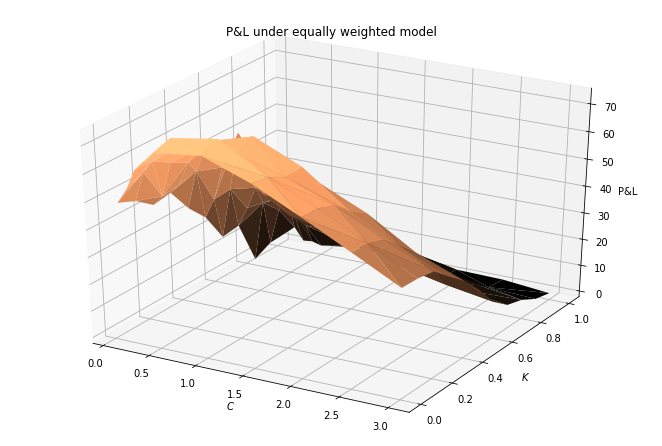

In [ ]:
CC = np.concatenate([np.arange(0.1,0.5,0.1),np.arange(0.5,3.5,0.5)])
KK = np.arange(0.0,1.1,0.1)
plot_3d_surf(CC,KK,pnls_10_ck_eq,'$C$','$K$','P&L','P&L under equally weighted model')

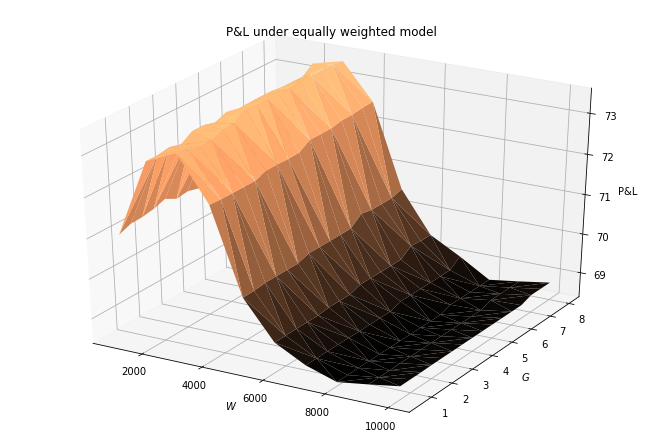

In [ ]:
WW = np.arange(1000,11000,1000)
GG = np.arange(0.5,8.5,0.5)
plot_3d_surf(WW,GG,pnls_10_wg_eq,'$W$','$G$','P&L','P&L under equally weighted model')

### `herd`

In [ ]:
pnls_5_pmax_herd = pnl_grid_over_P(train_ids_top5, 'herd', param='pmax', PP=np.arange(0.05,1.05,0.05), weight=weight, T=0.05, P=500, plot=False)
pnls_5_pmax_herd

100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


0.05     1.966900
0.10    18.016383
0.15     5.789843
0.20    14.393200
0.25    21.662984
0.30    31.873468
0.35    20.699283
0.40    13.197783
0.45    40.607483
0.50    17.829857
0.55    28.954306
0.60    21.992525
0.65    16.195843
0.70    38.762564
0.75    24.624233
0.80    16.401408
0.85    28.165701
0.90    24.740703
0.95    28.626832
1.00    35.657589
dtype: float64

In [ ]:
pnls_10_pmax_herd = pnl_grid_over_P(train_ids_top10, 'herd', param='pmax', PP=np.arange(0.05,1.05,0.05), weight=weight, T=0.05, P=500, plot=False)
pnls_10_pmax_herd

100%|██████████| 20/20 [02:41<00:00,  8.10s/it]


0.05     3.729653
0.10    -0.306109
0.15     9.633504
0.20     6.511244
0.25     4.136859
0.30    15.099343
0.35    12.789416
0.40     9.998516
0.45    12.118481
0.50    11.859616
0.55     5.909130
0.60    22.088708
0.65    15.595464
0.70    11.635413
0.75    22.941702
0.80    15.903022
0.85    24.385543
0.90    23.306004
0.95    17.550390
1.00    13.780643
dtype: float64

## Testing of Strategies

In [ ]:
n_orders_train = {id: ifp_liquid[id]['market']['n_orders'] for id in train_ids}
n_orders_test = {id: ifp_liquid[id]['market']['n_orders'] for id in test_ids}
n_orders_train = pd.Series(n_orders_train)
n_orders_test = pd.Series(n_orders_test)

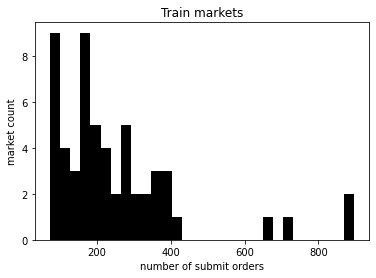

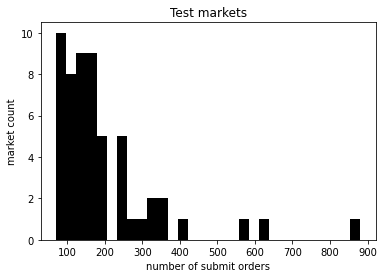

In [ ]:
plt.hist(n_orders_train, bins=30, color='k')
plt.title('Train markets')
plt.xlabel('number of submit orders')
plt.ylabel('market count')
plt.show()

plt.hist(n_orders_test, bins=30, color='k')
plt.title('Test markets')
plt.xlabel('number of submit orders')
plt.ylabel('market count')
plt.show()

In [ ]:
n_orders = pd.Series({id: ifp_liquid[id]['market']['n_orders'] for id in test_ids})
test_ids_top1 = n_orders.sort_values()[-1:].index.to_list()
test_ids_top5 = n_orders.sort_values()[-5:].index.to_list()
test_ids_top10 = n_orders.sort_values()[-10:].index.to_list()
test_ids_top15 = n_orders.sort_values()[-15:].index.to_list()
print(test_ids_top10)

['1146', '1188', '1177', '1143', '1179', '1165', '1176', '1168', '1213', '1159']


In [ ]:
def test_pnl(ids, strat, N=None, **kwargs):
    if N is None:
        N = np.arange(1,21)

    sims = backtest(ids, strat, **kwargs)
    print(f'average test P&L in top {len(ids)} markets:', np.mean([sims[id]['pnl']['port'] for id in sims]))

    pnls_over_N = list()
    for n in tqdm(N):
        test_ids_topn = n_orders.sort_values()[-n:].index.to_list()
        sims_cwm = backtest(test_ids_topn, strat, **kwargs)
        avg_pnl = np.mean([sims_cwm[id]['pnl']['port'] for id in sims_cwm])
        pnls_over_N.append(avg_pnl)
    pnls_over_N = np.array(pnls_over_N)

    plt.scatter(N,pnls_over_N,c='k')
    plt.title('Test P&L vs. market liquidity')
    plt.xlabel('top $N$ liquid markets')
    plt.ylabel('average P&L')
    plt.xticks(N)
    plt.show()

    plt.scatter(N,N*pnls_over_N,c='k')
    plt.title('Test P&L vs. market liquidity')
    plt.xlabel('top $N$ liquid markets')
    plt.ylabel('total P&L')
    plt.xticks(N)
    plt.show()

### `cwm`

average test P&L in top 5 markets: 113.58139281429642


100%|██████████| 20/20 [02:19<00:00,  6.99s/it]


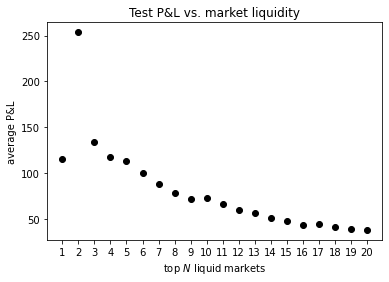

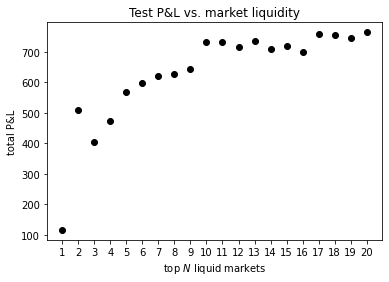

In [ ]:
test_pnl(test_ids_top5, 'cwm', weight=weight, C=1, K=0.1, W=5000, G=2, T=0.05, P=500, plot=False)

average test P&L in top 10 markets: 48.66908355820501


100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


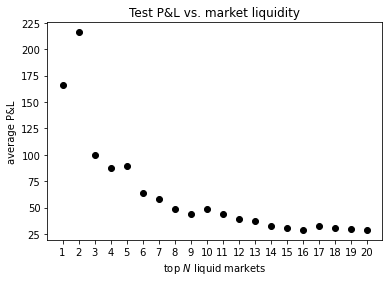

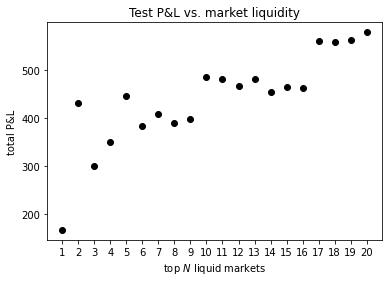

In [ ]:
test_pnl(test_ids_top10, 'cwm', weight=weight, C=0.4, K=0.3, W=1000, G=2, T=0.05, P=500, plot=False)

### `vol`

average test P&L in top 5 markets: 117.3566715992753


100%|██████████| 20/20 [01:47<00:00,  5.36s/it]


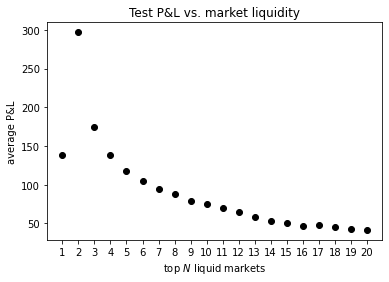

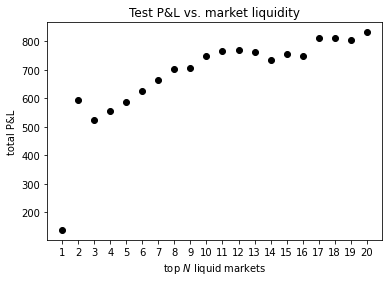

In [ ]:
test_pnl(test_ids_top5, 'vol', C=0.5, K=0.1, W=4000, G=7, wmax=0.25, T=0.05, P=500, plot=False)

average test P&L in top 10 markets: 74.93939152131358


100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


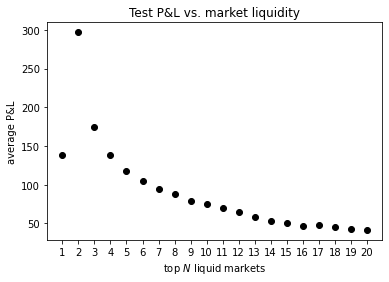

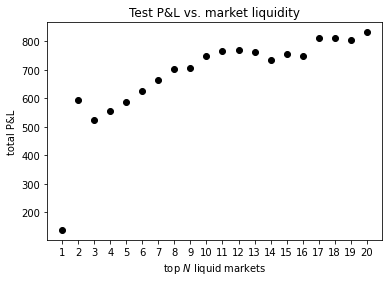

In [ ]:
test_pnl(test_ids_top10, 'vol', C=0.5, K=0.1, W=4000, G=7, wmax=0.25, T=0.05, P=500, plot=False)

### `eq`

average test P&L in top 5 markets: 83.6190251719288


100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


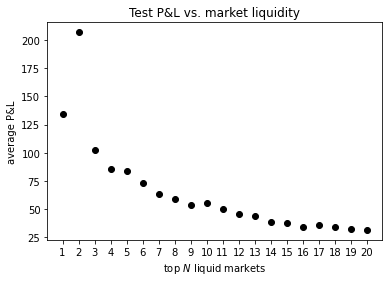

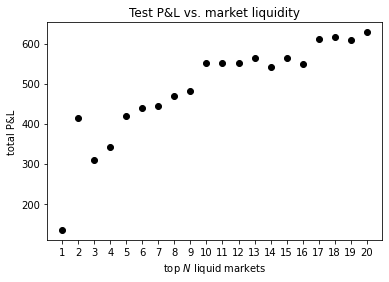

In [ ]:
test_pnl(test_ids_top5, 'eq', C=1, K=0.1, W=3000, G=2, w0=0.04, T=0.05, P=500, plot=False)

average test P&L in top 5 markets: 101.01763852161623


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


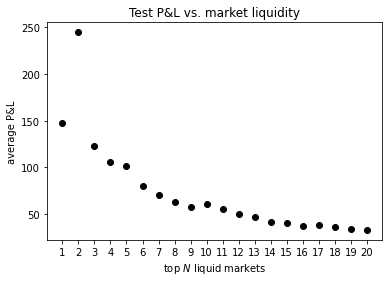

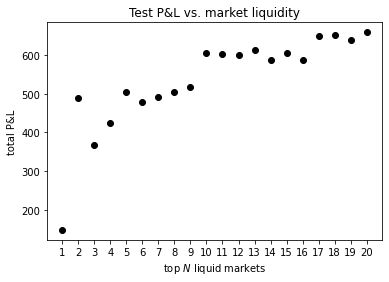

In [ ]:
test_pnl(test_ids_top5, 'eq', C=0.5, K=0.1, W=3000, G=2, w0=0.04, T=0.05, P=500, plot=False)

### `herd`

average test P&L in top 5 markets: 0.8715555555554424


100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


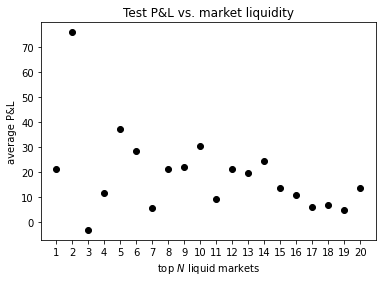

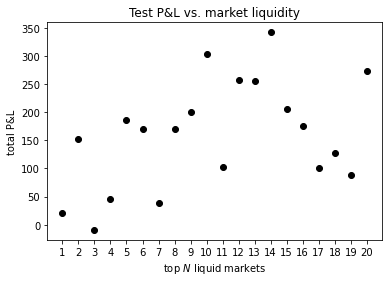

In [ ]:
test_pnl(test_ids_top5, 'herd', weight=weight, pmax=0.5, plot=False)

average test P&L in top 10 markets: 2.1694404761904478


100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


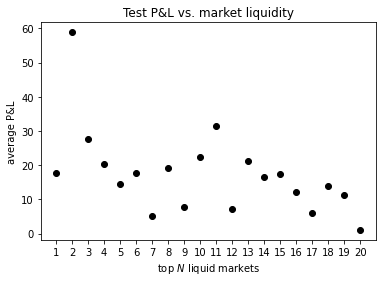

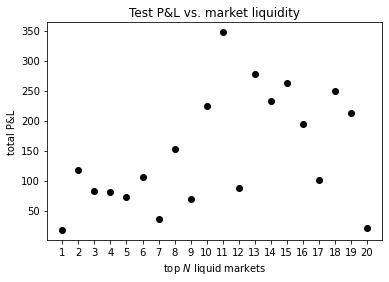

In [ ]:
test_pnl(test_ids_top10, 'herd', weight=weight, pmax=0.5, plot=False)

## Conclusion

In [ ]:
mkts_5 = {id: ifp_liquid[id] for id in test_ids_top5}
avg_pnl_5, cum_pnl_5 = ifp_liquid_summary(mkts=mkts_5, plot=False)
avg_pnl_5.mean(), avg_pnl_5.std()

(-36.63020304568527, 1108.0862834450343)

In [ ]:
mkts_10 = {id: ifp_liquid[id] for id in test_ids_top10}
avg_pnl_10, cum_pnl_10 = ifp_liquid_summary(mkts=mkts_10, plot=False)
avg_pnl_10.mean(), avg_pnl_10.std()

(-10.085915587918018, 685.3501429280964)

In [ ]:
# cwm 5: 113.58139281429642 10: 48.66908355820501
sum(avg_pnl_5<113.58139281429642)/len(avg_pnl_5), sum(avg_pnl_10<48.66908355820501)/len(avg_pnl_10)

(0.7817258883248731, 0.7621359223300971)